## <center>**PROJECT: ```COVID-19 Detection using Lungs X-ray Images with Traditional ML Models and Feature Extracting Techniques ```**</center>

### **Imports**

In [74]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from skimage.io import imread, imshow
from skimage.transform import resize
from IPython.display import display
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import plotly.express as px
from sklearn import metrics
from sklearn import tree
from pathlib import Path
from PIL import Image
# import pandas as pd
import numpy as np
import itertools
import graphviz 
import random
import shutil
import time
import cv2
import os

### **Dataset Preprocessing and Folder setup**

In [75]:
cwd = os.getcwd()
cwd

'e:\\My Projects\\AI-ML\\Vision\\Covid-19 Classification'

In [76]:
# Define the root folder containing Dataset folder
root_folder = "Dataset/COVID-19_Radiography_Dataset"
root_folder = os.path.join(cwd, root_folder)
print(root_folder)

root_folder_dataset = "Dataset/COVID-19_Radiography_Images_Final"
root_folder_dataset = os.path.join(cwd, root_folder_dataset)
print(root_folder_dataset)

# Define the paths for training, testing, and validation folders
train_folder = os.path.join(cwd,root_folder_dataset, "train")
test_folder = os.path.join(cwd,root_folder_dataset, "test")
val_folder = os.path.join(cwd, root_folder_dataset, "valid")

print(train_folder)

# Get all classes in the dataset folder
classes = os.listdir(train_folder)
classes

e:\My Projects\AI-ML\Vision\Covid-19 Classification\Dataset/COVID-19_Radiography_Dataset
e:\My Projects\AI-ML\Vision\Covid-19 Classification\Dataset/COVID-19_Radiography_Images_Final
e:\My Projects\AI-ML\Vision\Covid-19 Classification\Dataset/COVID-19_Radiography_Images_Final\train


['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [4]:
# for class_name in classes:
#     class_folder = os.path.join(root_folder, class_name) # Folder path
    
#     # Get list of images in the class folder
#     images = os.listdir(class_folder)
    
#     # Split images into training, testing, and validation sets
#     train_images, test_val_images = train_test_split(images, test_size=0.3, random_state=42)
#     test_images, val_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

#     # Move images to respective folders
#     for image in train_images:
#         print(os.path.join(class_folder, image))
#         shutil.move(os.path.join(class_folder, image), os.path.join(train_folder, class_name))
        
#     for image in test_images:
#         shutil.move(os.path.join(class_folder, image), os.path.join(test_folder ,class_name))
#     for image in val_images:
#         shutil.move(os.path.join(class_folder, image), os.path.join(val_folder ,class_name))

# **EDA**

### **Visualizing Random Images out of Training set**

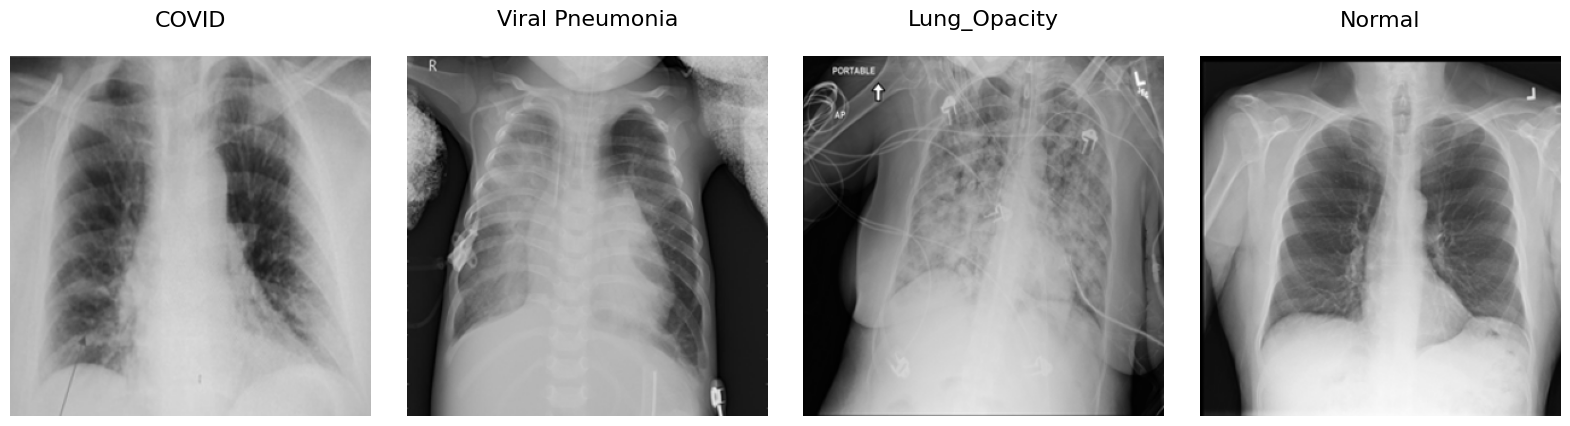

In [5]:
def display_random_images(root_dir, num_images):
    # Get list of all folders in the root directory
    folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    
    # Initialize a list to store selected images and their names
    selected_images = []
    selected_image_names = []
    
    # Iterate through each folder and randomly select an image
    for folder in folders:
        folder_path = os.path.join(root_dir, folder)
        images = [img for img in os.listdir(folder_path) if img.endswith(".jpg") or img.endswith(".png")]
        if images:
            selected_image = random.choice(images)
            selected_image_path = os.path.join(folder_path, selected_image)
            selected_images.append(selected_image_path)
            selected_image_names.append(folder)  # Assuming folder name as image name
    
    # Randomly select num_images from the selected images list
    selected_indices = random.sample(range(len(selected_images)), min(num_images, len(selected_images)))
    
    # Display the selected images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 6))  # Increase the width and decrease the height of the figure
    for i, idx in enumerate(selected_indices):
        img = Image.open(selected_images[idx])
        img = img.convert("RGB")  # Convert BGR to RGB
        axes[i].imshow(img)
        axes[i].axis('off')
        # Get the dimensions of the image
        width, height = img.size
        # Set text properties such as alignment and size
        axes[i].text(width/2, -0.1*height, selected_image_names[idx], fontsize=16, ha='center', va='center')
    plt.subplots_adjust(wspace=0.1)  # Adjust spacing between subplots
    plt.show()

num_images_to_display = 4
display_random_images(train_folder, num_images_to_display)

### **Visualization of Classes Counts for Training Dataset**

In [6]:
class_counts = {}
for class_name in classes:
    class_folder = os.path.join(root_folder_dataset, "train", class_name) # Folder path

    # Get list of images in the class folder
    images = os.listdir(class_folder)
    leng_img = len(images)
    class_counts[class_name] = leng_img

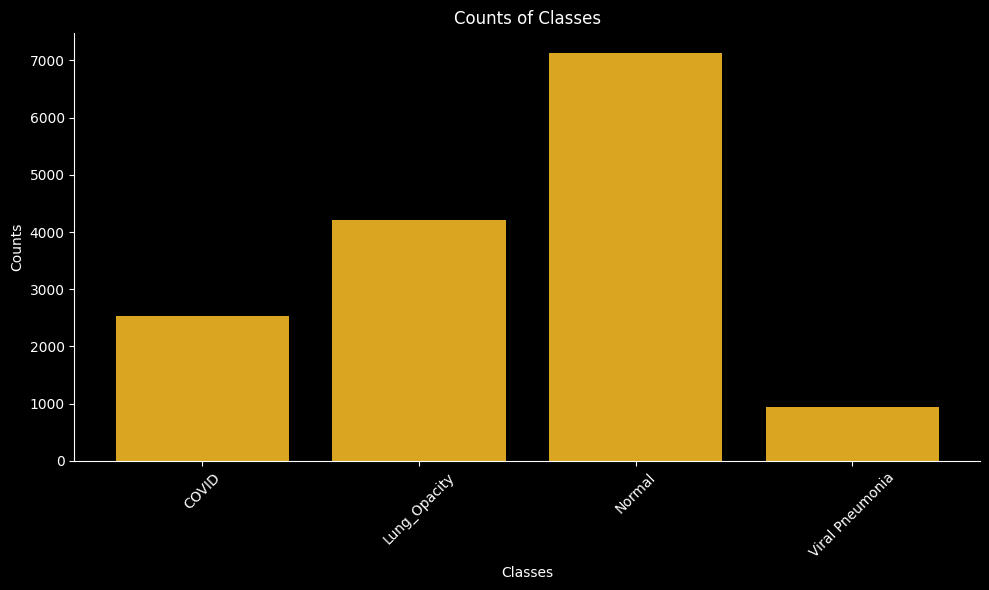

In [7]:
# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create bar graph
fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(classes, counts, color='goldenrod')  # Set the color of the bars to golden
ax.set_facecolor('black')  # Set background color within the bar area to black
plt.xlabel('Classes', color='white')  # Set label color to white
plt.ylabel('Counts', color='white')  # Set label color to white
plt.title('Counts of Classes', color='white')  # Set title color to white
plt.xticks(rotation=45, color='white')  # Rotate class labels and set color to white for better visibility if needed
plt.yticks(color='white')  # Set color of y-axis ticks to white
fig.set_facecolor('black')  # Set background color of the entire figure to black

# Set color of ticks and spines (axis lines)
ax.tick_params(axis='both', colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### **Visualization of Images Dimensions**

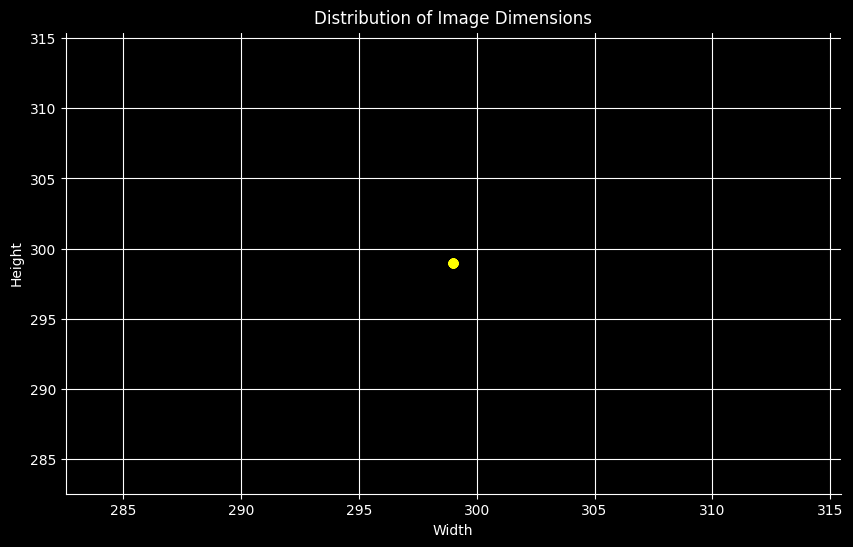

In [8]:
def plot_image_dimensions_distribution(root_folder_dataset):
    image_dimensions = []

    for class_name in os.listdir(os.path.join(root_folder_dataset, "train")):
        class_folder = os.path.join(root_folder_dataset, "train", class_name)
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            img = Image.open(image_path)
            width, height = img.size
            image_dimensions.append((width, height))

    width, height = zip(*image_dimensions)

    plt.figure(figsize=(10, 6), facecolor='black')  # Set figure facecolor to black
    plt.scatter(width, height, alpha=0.5, color='yellow')
    plt.title('Distribution of Image Dimensions', color='white')  # Set title color to white
    plt.xlabel('Width', color='white')  # Set xlabel color to white
    plt.ylabel('Height', color='white')  # Set ylabel color to white
    plt.grid(True, color='white')  # Change grid lines color to white
    plt.gca().set_facecolor('black')  # Change background color to black
    plt.tick_params(axis='x', colors='white')  # Set x-axis tick color to white
    plt.tick_params(axis='y', colors='white')  # Set y-axis tick color to white
    plt.gca().spines['bottom'].set_color('white')  # Set color of x-axis spine to white
    plt.gca().spines['left'].set_color('white')  # Set color of y-axis spine to white
    plt.show()

root_folder_dataset = 'Dataset/COVID-19_Radiography_Images_Final'
plot_image_dimensions_distribution(root_folder_dataset)


# **Feature Engineering**

#### ```Using Manual Feature Extraction using Classical / Traditional Feature Descriptors```

In [77]:
training_set = 'Dataset/COVID-19_Radiography_Images_Final/train'
validation_set = 'Dataset/COVID-19_Radiography_Images_Final/valid'
testing_set = 'Dataset/COVID-19_Radiography_Images_Final/test'

### **HOG**

In [6]:
# Function to load images from a folder
def load_images_from_folder(folder):
    data = []
    labels = []
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
                if image is not None:
                    data.append(image)
                    labels.append(class_folder)
    return data, labels

# Step 1: Load Training Data
X_train, y_train = load_images_from_folder(training_set)

# Step 2: Extract HOG Features for Training Data
def extract_hog_features(data):
    hog_features = []
    for image in data:
        # You can adjust parameters based on your needs
        features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)
    return hog_features

##### ```HOG Feature Visualization```

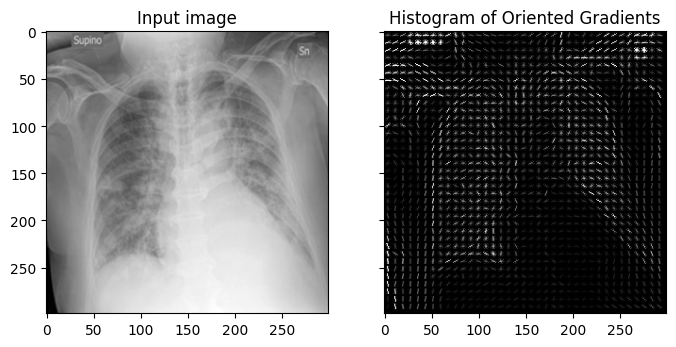

In [21]:
# Load first Image from X_train
image = X_train[0]

# Extract HOG features
hog_features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)

# Display original image
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display HOG image
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

##### ```Decsion Tree```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.39      0.41      0.40       543
   Lung_Opacity       0.48      0.48      0.48       902
         Normal       0.67      0.67      0.67      1529
Viral Pneumonia       0.55      0.50      0.53       202

       accuracy                           0.56      3176
      macro avg       0.52      0.52      0.52      3176
   weighted avg       0.56      0.56      0.56      3176



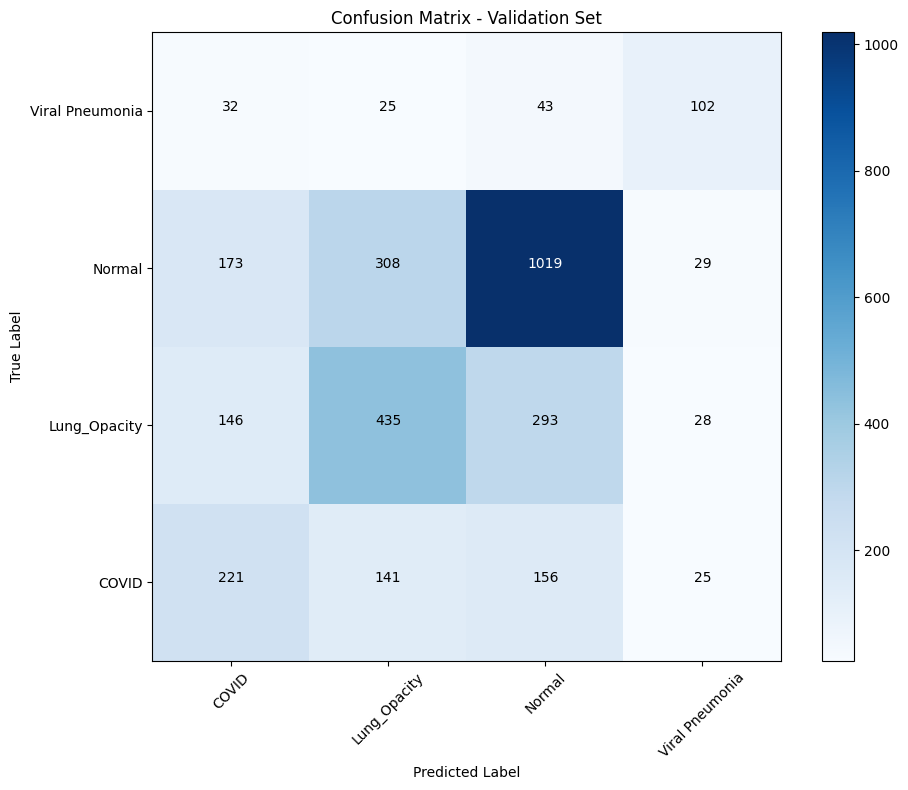


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.38      0.41      0.40       542
   Lung_Opacity       0.51      0.49      0.50       902
         Normal       0.67      0.67      0.67      1529
Viral Pneumonia       0.49      0.48      0.48       202

       accuracy                           0.56      3175
      macro avg       0.51      0.51      0.51      3175
   weighted avg       0.56      0.56      0.56      3175



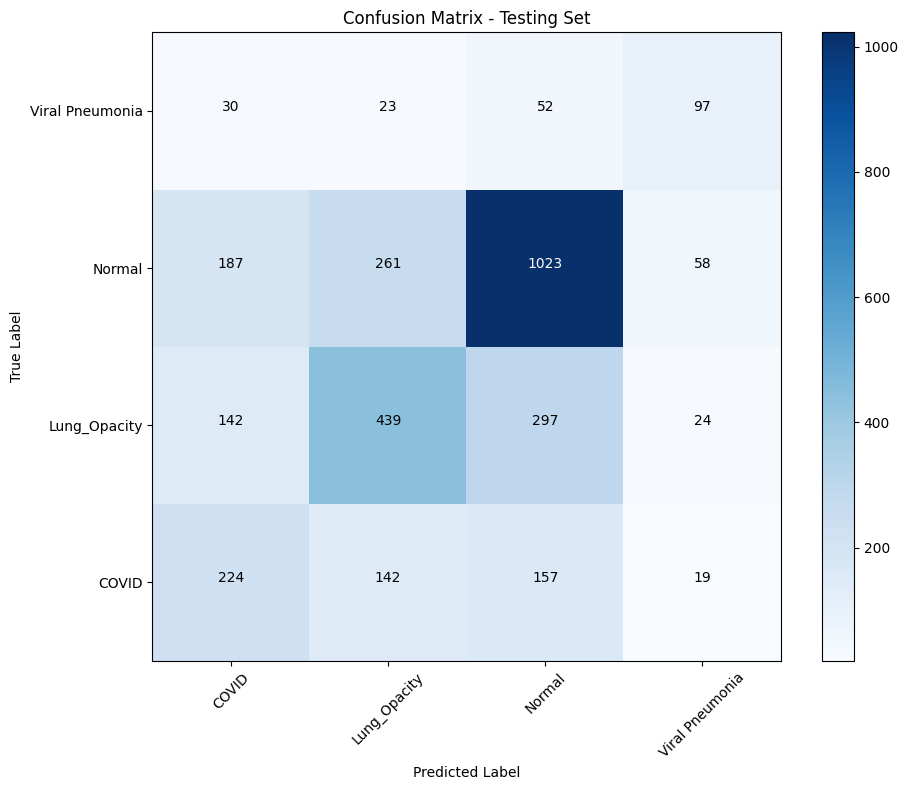

In [20]:
from sklearn.tree import DecisionTreeClassifier

X_train_hog = extract_hog_features(X_train)

# Step 3: Train a Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_hog, y_train)

# Step 4: Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Step 5: Extract HOG Features for Validation Data
X_val_hog = extract_hog_features(X_val)

# Step 6: Evaluate Model on Validation Set
val_predictions = decision_tree.predict(X_val_hog)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Step 7: Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Step 8: Extract HOG Features for Testing Data
X_test_hog = extract_hog_features(X_test)

# Step 9: Evaluate Model on Testing Set
test_predictions = decision_tree.predict(X_test_hog)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```KNN```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.49      0.82      0.61       543
   Lung_Opacity       0.77      0.49      0.60       902
         Normal       0.83      0.81      0.82      1529
Viral Pneumonia       0.95      0.90      0.92       202

       accuracy                           0.73      3176
      macro avg       0.76      0.75      0.74      3176
   weighted avg       0.76      0.73      0.73      3176



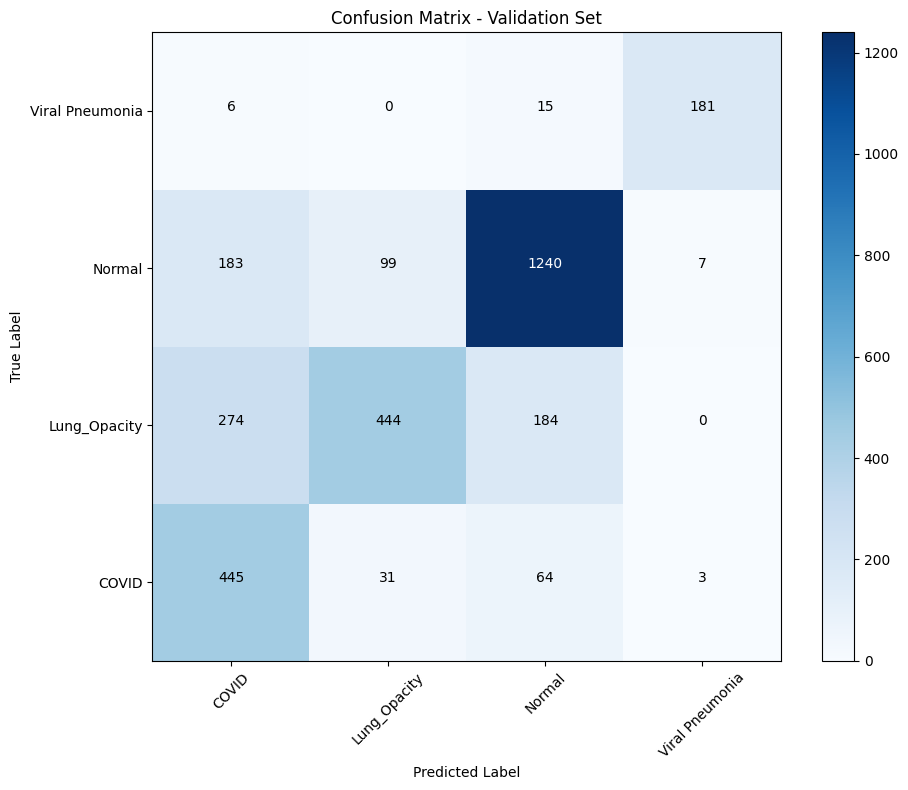


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.47      0.80      0.60       542
   Lung_Opacity       0.75      0.51      0.61       902
         Normal       0.84      0.79      0.82      1529
Viral Pneumonia       0.91      0.91      0.91       202

       accuracy                           0.72      3175
      macro avg       0.74      0.75      0.73      3175
   weighted avg       0.76      0.72      0.73      3175



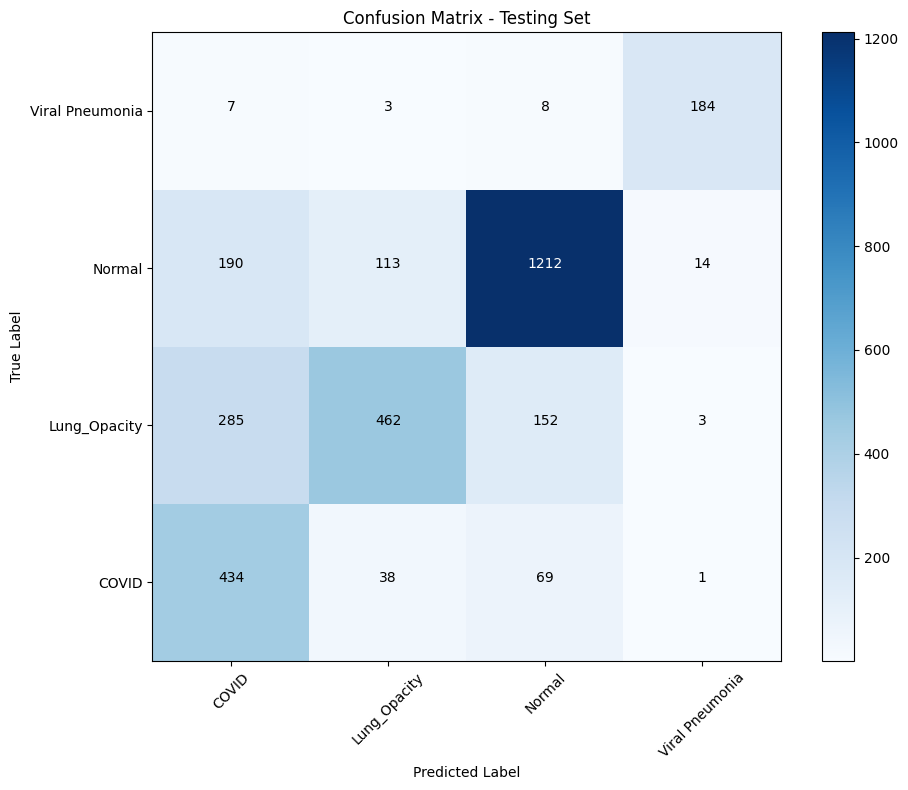

In [21]:
from sklearn.neighbors import KNeighborsClassifier

X_train_hog = extract_hog_features(X_train)

# Step 3: Train a Model
knn = KNeighborsClassifier()
knn.fit(X_train_hog, y_train)

# Step 4: Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Step 5: Extract HOG Features for Validation Data
X_val_hog = extract_hog_features(X_val)

# Step 6: Evaluate Model on Validation Set
val_predictions = knn.predict(X_val_hog)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Step 7: Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Step 8: Extract HOG Features for Testing Data
X_test_hog = extract_hog_features(X_test)

# Step 9: Evaluate Model on Testing Set
test_predictions = knn.predict(X_test_hog)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Naive Bayes```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.51      0.58      0.55       543
   Lung_Opacity       0.66      0.65      0.65       902
         Normal       0.77      0.65      0.71      1529
Viral Pneumonia       0.48      0.88      0.62       202

       accuracy                           0.65      3176
      macro avg       0.60      0.69      0.63      3176
   weighted avg       0.67      0.65      0.66      3176



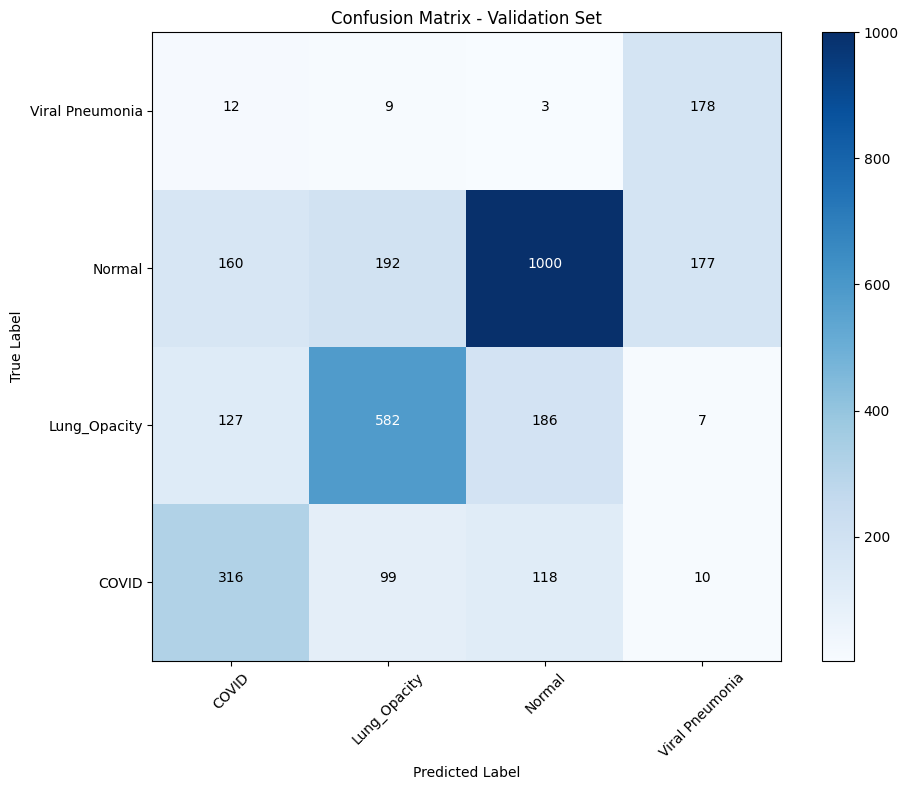


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.53      0.60      0.56       542
   Lung_Opacity       0.66      0.68      0.67       902
         Normal       0.77      0.63      0.69      1529
Viral Pneumonia       0.45      0.88      0.59       202

       accuracy                           0.65      3175
      macro avg       0.60      0.70      0.63      3175
   weighted avg       0.68      0.65      0.66      3175



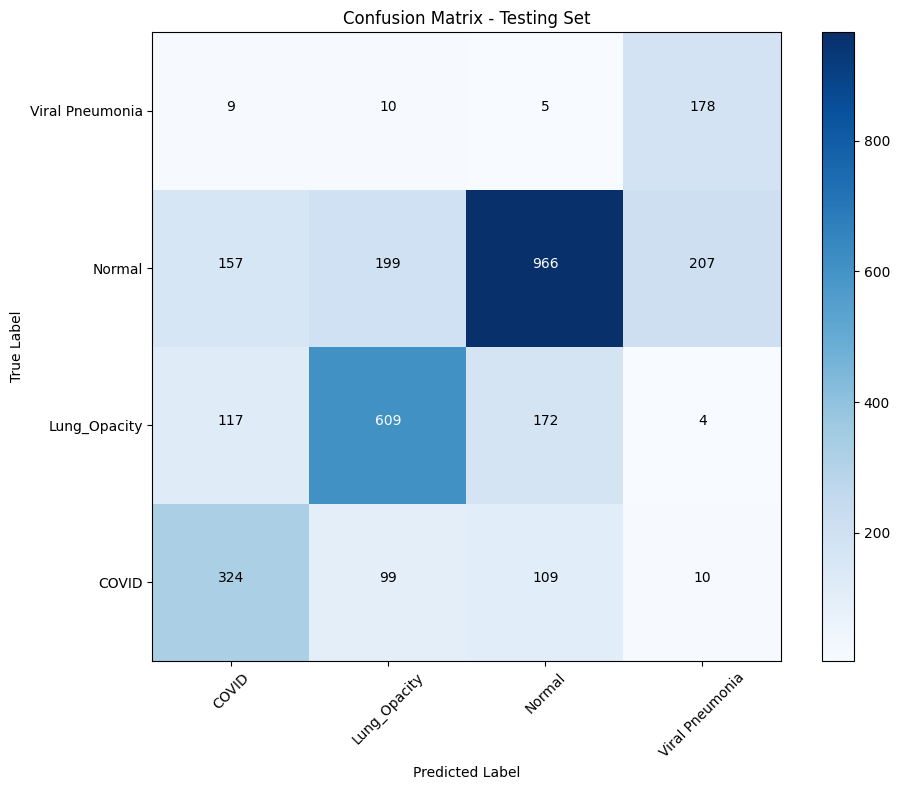

In [22]:
from sklearn.naive_bayes import GaussianNB

X_train_hog = extract_hog_features(X_train)

# Step 3: Train a Model
naive_b = GaussianNB()
naive_b.fit(X_train_hog, y_train)

# Step 4: Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Step 5: Extract HOG Features for Validation Data
X_val_hog = extract_hog_features(X_val)

# Step 6: Evaluate Model on Validation Set
val_predictions = naive_b.predict(X_val_hog)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Step 7: Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Step 8: Extract HOG Features for Testing Data
X_test_hog = extract_hog_features(X_test)

# Step 9: Evaluate Model on Testing Set
test_predictions = naive_b.predict(X_test_hog)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```SVM```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.90      0.81      0.85       543
   Lung_Opacity       0.84      0.77      0.80       902
         Normal       0.85      0.93      0.89      1529
Viral Pneumonia       0.98      0.91      0.95       202

       accuracy                           0.86      3176
      macro avg       0.89      0.86      0.87      3176
   weighted avg       0.86      0.86      0.86      3176



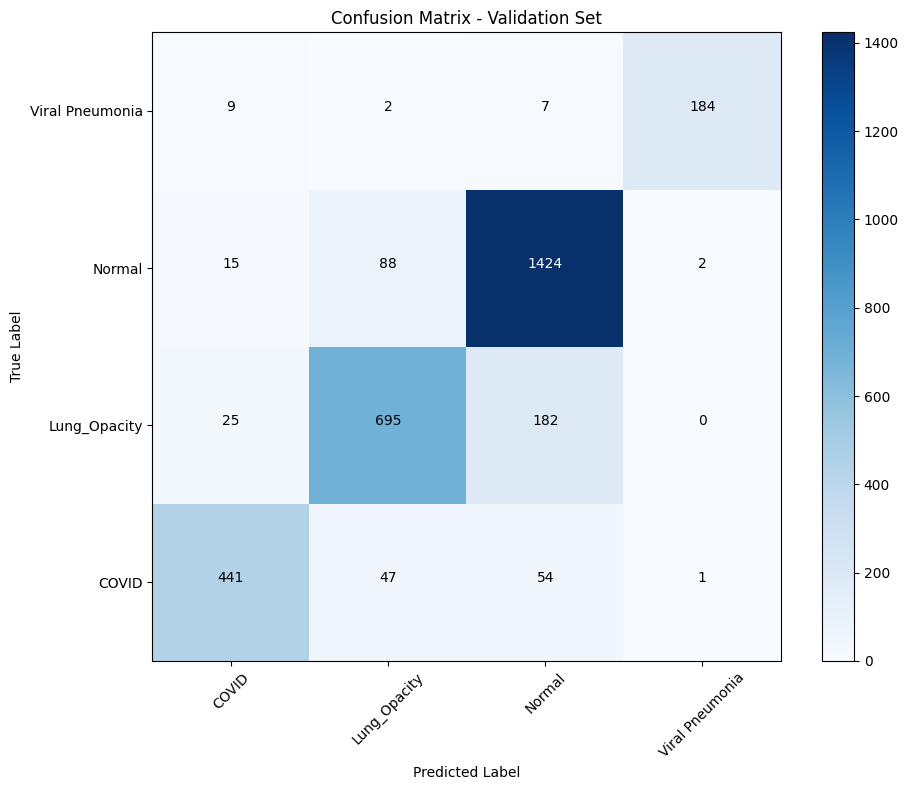


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.90      0.81      0.85       542
   Lung_Opacity       0.83      0.79      0.81       902
         Normal       0.85      0.92      0.88      1529
Viral Pneumonia       0.98      0.93      0.95       202

       accuracy                           0.86      3175
      macro avg       0.89      0.86      0.88      3175
   weighted avg       0.86      0.86      0.86      3175



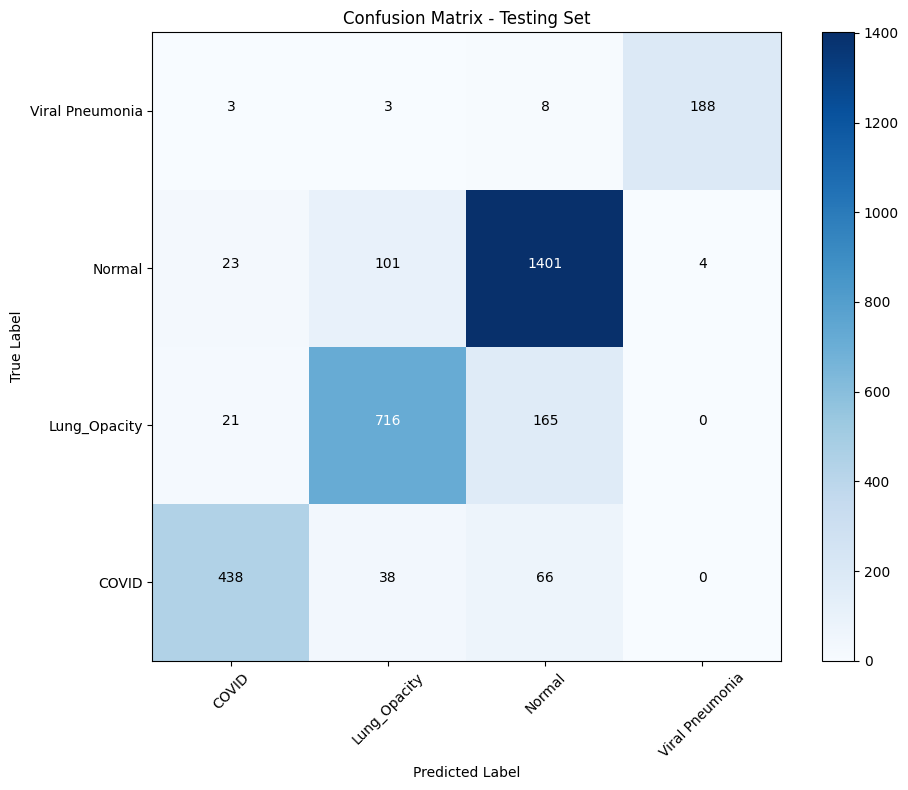

In [23]:
from sklearn import svm

X_train_hog = extract_hog_features(X_train)

# Step 3: Train a Model
svm_model = svm.SVC()
svm_model.fit(X_train_hog, y_train)

# Step 4: Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Step 5: Extract HOG Features for Validation Data
X_val_hog = extract_hog_features(X_val)

# Step 6: Evaluate Model on Validation Set
val_predictions = svm_model.predict(X_val_hog)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Step 7: Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Step 8: Extract HOG Features for Testing Data
X_test_hog = extract_hog_features(X_test)

# Step 9: Evaluate Model on Testing Set
test_predictions = svm_model.predict(X_test_hog)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

### **ORB**

In [78]:
def load_images_from_folder(folder):
    data = []
    labels = []
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
                if image is not None:
                    data.append(image)
                    labels.append(class_folder)
    return data, labels

# Step 1: Load Training Data
X_train, y_train = load_images_from_folder(training_set)

# Step 2: Extract ORB Features for Training Data
def extract_orb_features(data):
    orb = cv2.ORB_create()
    orb_features = []
    for image in data:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is not None:
            orb_features.append(descriptors)
        else:
            orb_features.append(np.zeros((1, 32), dtype=np.float32))  # Placeholder for empty descriptors
    return orb_features

In [81]:
# Extract ORB features
X_train_orb = extract_orb_features(X_train)

In [83]:
lengths_xtrainorb = []
for i in X_train_orb:
    lengths_xtrainorb.append(len(i))

##### ```ORB Feature lengths distribution Visualization```

The reason for doing that is here we can know about using the two main approaches
* ```Approach 1: Most Frequently Occuring (MODE)``` : Checking up on common lengths of features using the distribution graph to get a number from there and truncate all other features after that number (to make equal features to pass them to a model) 
* ```Approach 2: Taking Average (MEAN)``` : Taking avg or mean value using feature lengths and truncate all other features after that number (to make equal features to pass them to a model) 
* ```Approach 3: Taking Largest Feature Vector``` : Taking largest feature vector length and add zeros to remaining feature vectors (to make equal features to pass them to a model) 

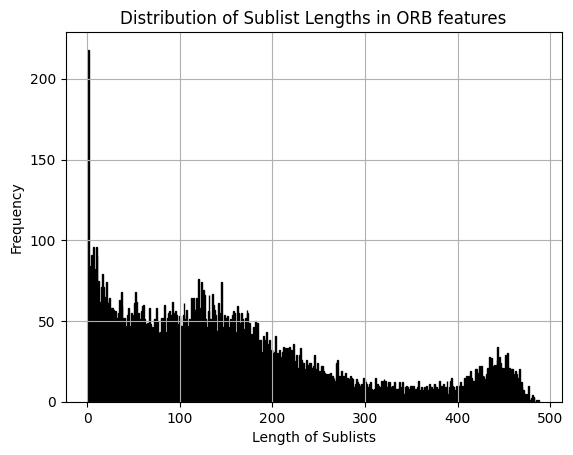

In [21]:
import matplotlib.pyplot as plt

# Get the lengths of the sublists in X_train
lengths = [len(sublist) for sublist in X_train_orb]

# Plot the distribution of counts
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1), edgecolor='black')
plt.xlabel('Length of Sublists')
plt.ylabel('Frequency')
plt.title('Distribution of Sublist Lengths in ORB features')
plt.grid(True)
plt.show()

In [21]:
# Flatten the features
# X_train_orb_flat = np.array([descriptor for sublist in X_train_orb for descriptor in sublist])

##### ```ORB Feature Keypoints Visualization```

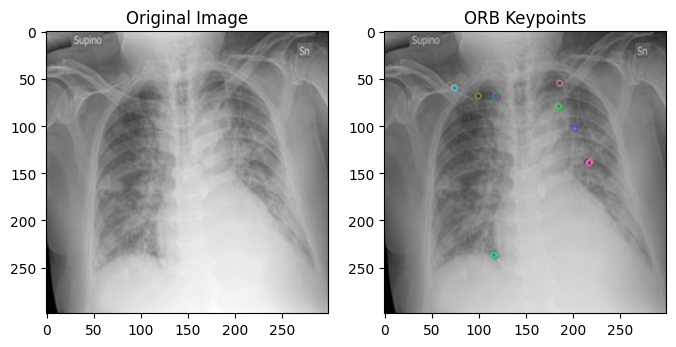

In [47]:
# Load first Image from X_train
image = X_train[0]

# Extract ORB features
orb = cv2.ORB_create()
keypoints, orb_image = orb.detectAndCompute(image, None)

Image_keypoint1 = cv2.drawKeypoints(image, keypoints, None)

# Plot both images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# Display original image
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')

# Draw keypoints on the original image
# cv2.drawKeypoints(image, Image_keypoint1, image, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax2.imshow(Image_keypoint1, cmap='gray')
ax2.set_title('ORB Keypoints')

plt.show()

##### ```Approach 1: Most Frequently Occuring (MODE)```

In [43]:
def approach1_extract_orb_features(data, max_features):
    orb = cv2.ORB_create()
    orb_features = []
    for image in data:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()  # Flatten to make it 1D
            if len(descriptors) >= max_features:
                orb_features.append(descriptors[:max_features])
            else:
                # Append zeros to make up to max_features
                padded_descriptors = np.concatenate([descriptors, np.zeros(max_features - len(descriptors), dtype=np.float32)])
                orb_features.append(padded_descriptors)
        else:
            # If no descriptors found, append zeros
            orb_features.append(np.zeros(max_features, dtype=np.float32))
    return orb_features

##### ```Taking Most Frequent Feature Vector Lengths (MODE)```

In [59]:
lengths_xtrainorb = []
for i in X_train_orb:
    lengths_xtrainorb.append(len(i))

In [65]:
import statistics

# Find the mode
mode_length = statistics.mode(lengths_xtrainorb)

# Check if mode is less than 20
if mode_length < 20:
    # Calculate frequencies of each value
    freq_dict = {x: lengths_xtrainorb.count(x) for x in set(lengths_xtrainorb)}
    # Sort frequencies in descending order
    sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    # Find the next frequent value with a length of 20 or greater
    for length, freq in sorted_freq:
        if length >= 20:
            mode_length = length
            break

print("Mode (most frequent length):", mode_length)

Mode (most frequent length): 120


#### **Model Implementation**

##### ```Decsion Tree```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.25      0.26      0.26       543
   Lung_Opacity       0.28      0.27      0.28       902
         Normal       0.51      0.49      0.50      1529
Viral Pneumonia       0.10      0.12      0.11       202

       accuracy                           0.37      3176
      macro avg       0.28      0.29      0.29      3176
   weighted avg       0.37      0.37      0.37      3176



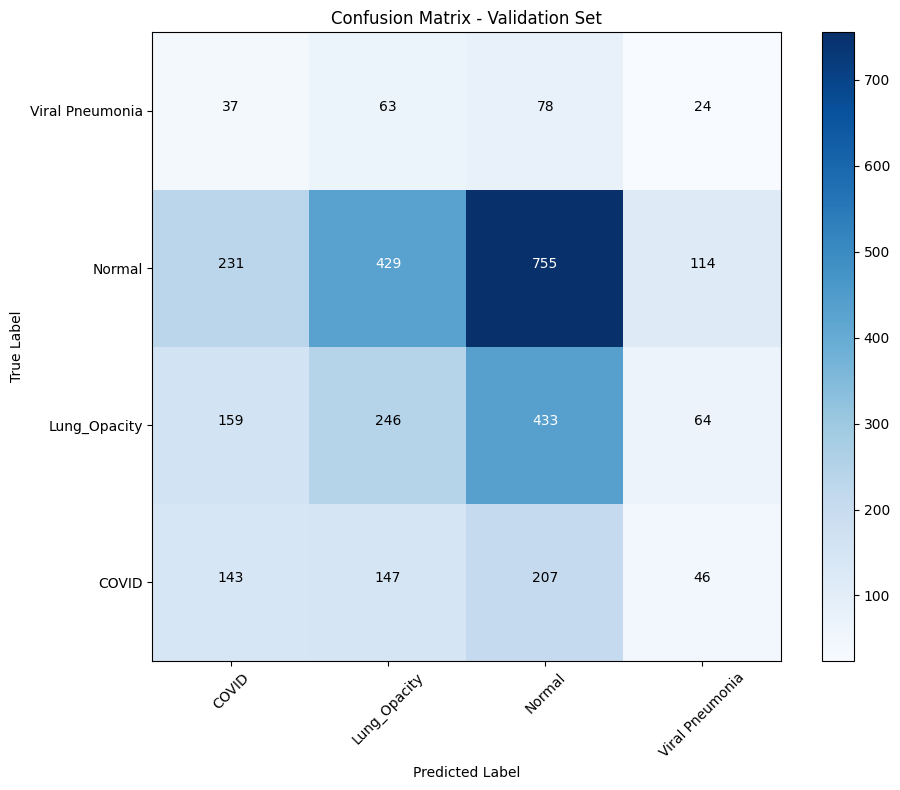


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.27      0.29      0.28       542
   Lung_Opacity       0.32      0.32      0.32       902
         Normal       0.52      0.50      0.51      1529
Viral Pneumonia       0.08      0.09      0.09       202

       accuracy                           0.39      3175
      macro avg       0.30      0.30      0.30      3175
   weighted avg       0.39      0.39      0.39      3175



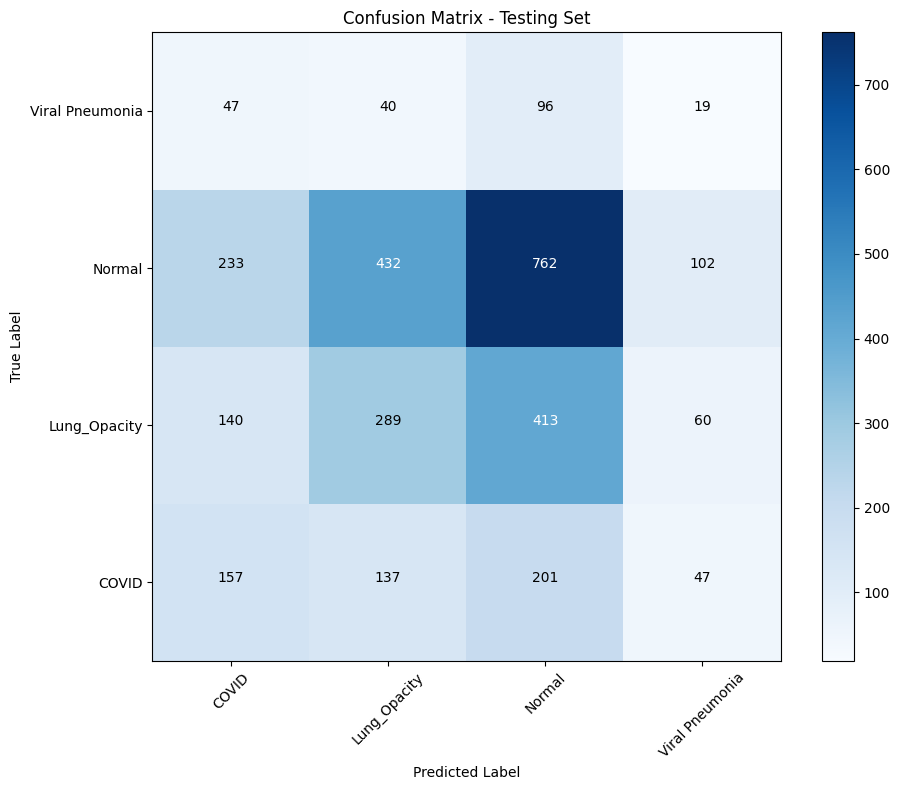

In [66]:
from sklearn.tree import DecisionTreeClassifier

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = decision_tree.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = decision_tree.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```KNN```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.31      0.34      0.32       543
   Lung_Opacity       0.35      0.30      0.33       902
         Normal       0.55      0.63      0.58      1529
Viral Pneumonia       0.21      0.03      0.06       202

       accuracy                           0.45      3176
      macro avg       0.35      0.33      0.32      3176
   weighted avg       0.43      0.45      0.43      3176



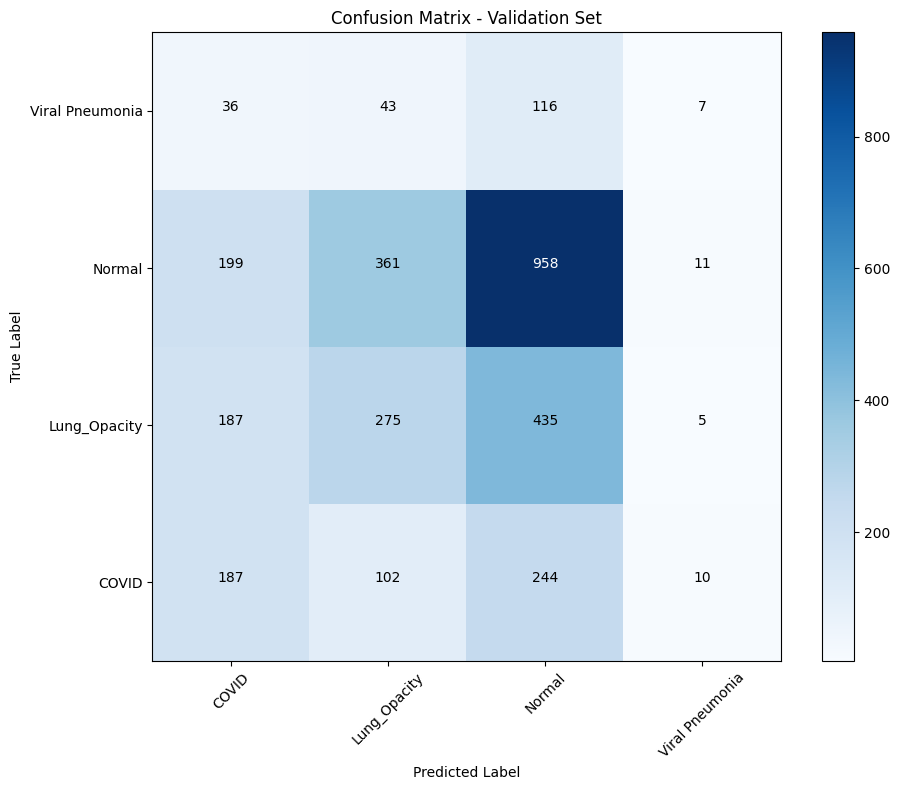


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.29      0.35      0.32       542
   Lung_Opacity       0.37      0.33      0.35       902
         Normal       0.55      0.61      0.58      1529
Viral Pneumonia       0.17      0.03      0.06       202

       accuracy                           0.45      3175
      macro avg       0.35      0.33      0.32      3175
   weighted avg       0.43      0.45      0.43      3175



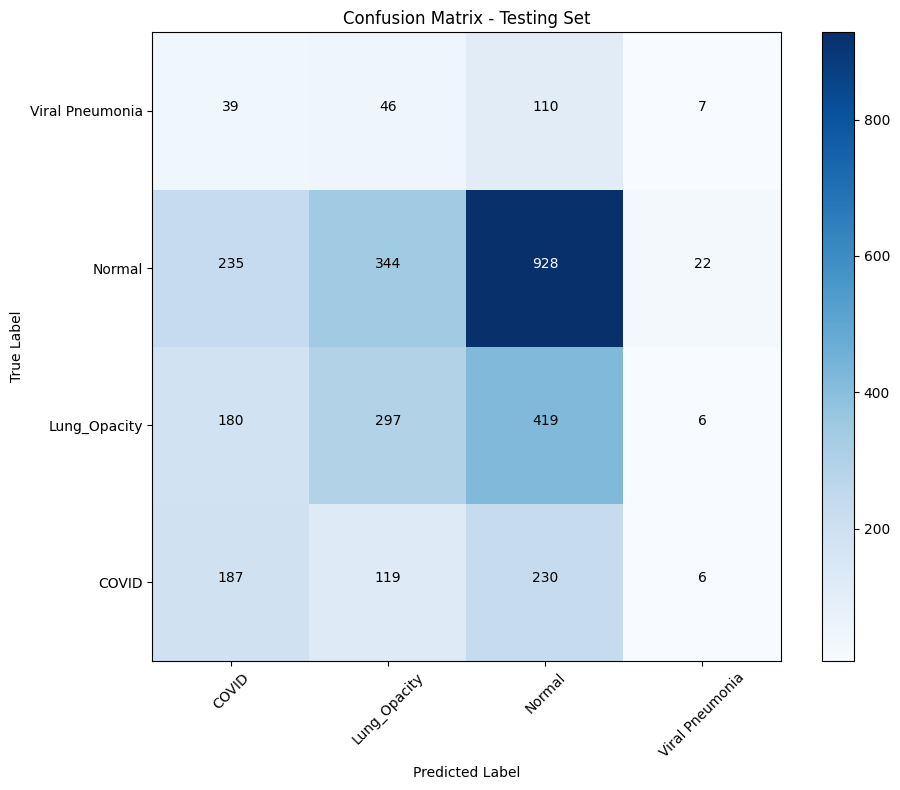

In [67]:
from sklearn.neighbors import KNeighborsClassifier

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
Knn_classifier = KNeighborsClassifier()
Knn_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = Knn_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = Knn_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Naive Bayes```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.27      0.34      0.30       543
   Lung_Opacity       0.42      0.19      0.26       902
         Normal       0.55      0.61      0.58      1529
Viral Pneumonia       0.15      0.31      0.20       202

       accuracy                           0.42      3176
      macro avg       0.35      0.36      0.33      3176
   weighted avg       0.44      0.42      0.42      3176



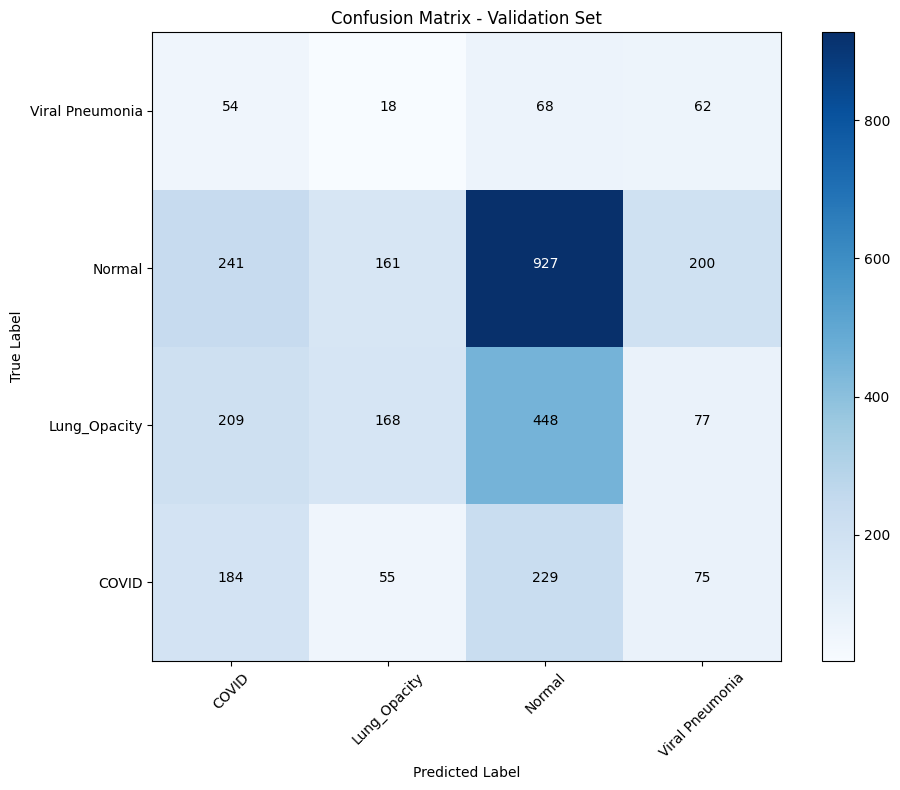


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.41      0.35       542
   Lung_Opacity       0.40      0.18      0.25       902
         Normal       0.55      0.59      0.56      1529
Viral Pneumonia       0.13      0.25      0.17       202

       accuracy                           0.42      3175
      macro avg       0.34      0.36      0.33      3175
   weighted avg       0.44      0.42      0.41      3175



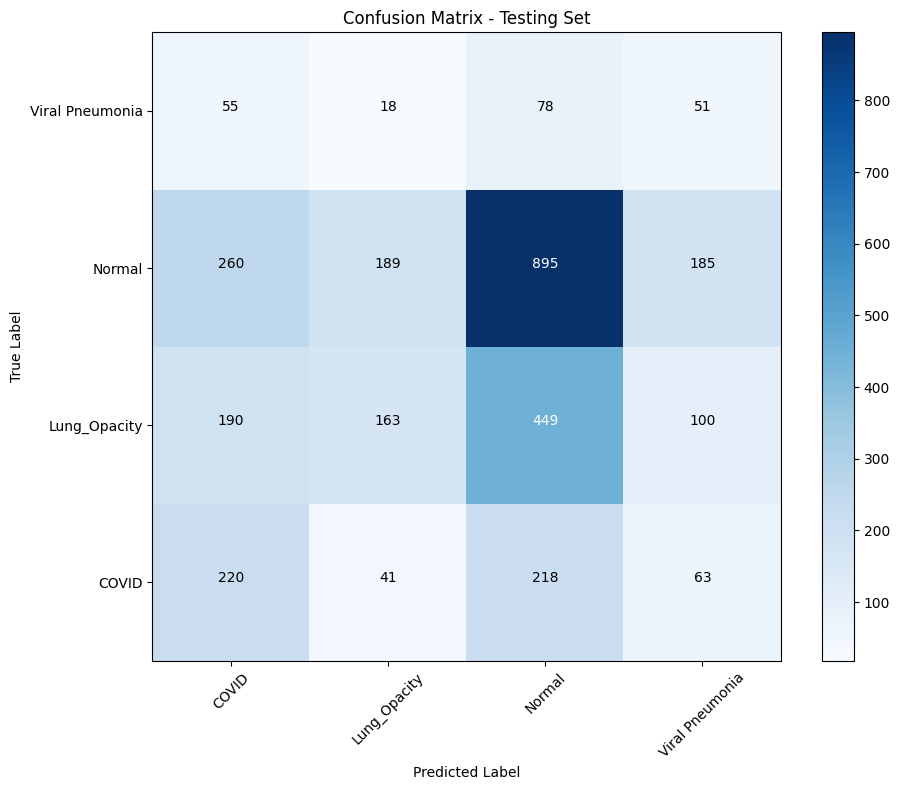

In [68]:
from sklearn.naive_bayes import GaussianNB

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
NB_classifier = GaussianNB()
NB_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = NB_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = NB_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```SVM```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.40      0.17      0.23       543
   Lung_Opacity       0.48      0.14      0.21       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3176
      macro avg       0.35      0.30      0.28      3176
   weighted avg       0.45      0.51      0.42      3176



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

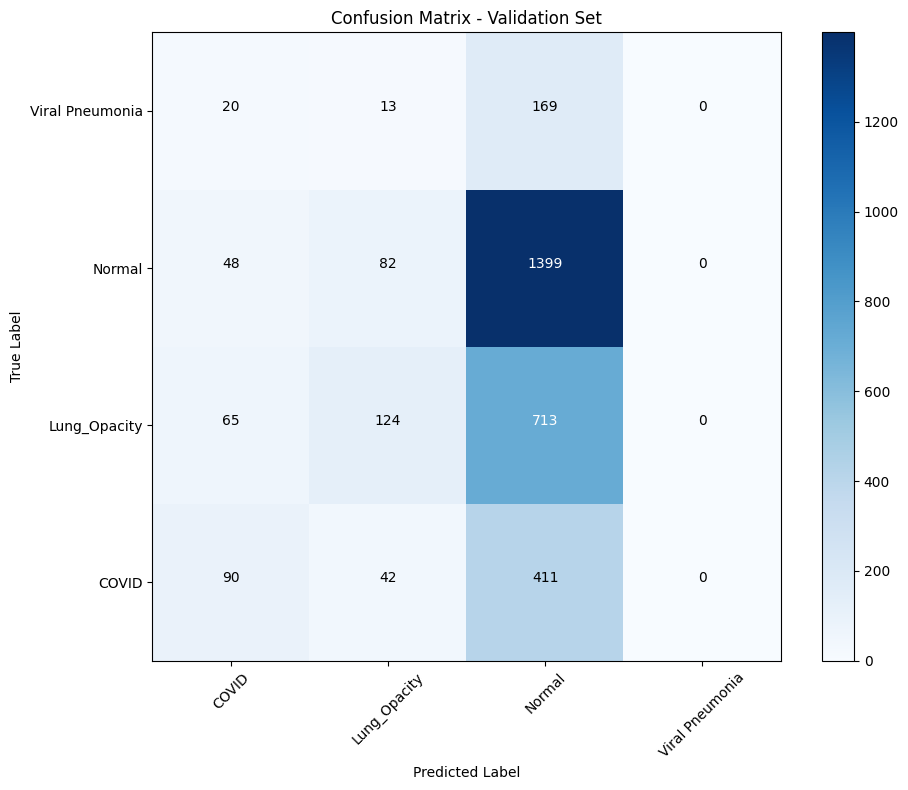


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.48      0.20      0.29       542
   Lung_Opacity       0.47      0.14      0.22       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3175
      macro avg       0.37      0.31      0.29      3175
   weighted avg       0.47      0.51      0.43      3175



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

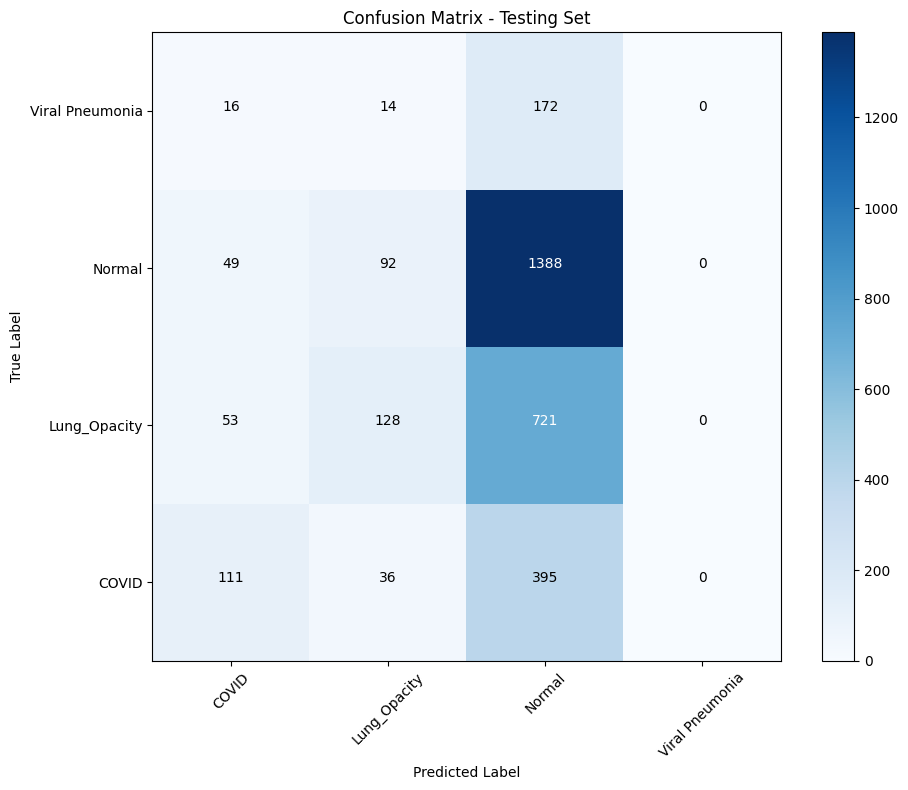

In [69]:
from sklearn import svm

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = svm_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = svm_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Approach 2: Taking Average (MEAN)```

In [70]:
def approach2_extract_orb_features(data, max_features):
    orb = cv2.ORB_create()
    orb_features = []
    for image in data:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()  # Flatten to make it 1D
            if len(descriptors) >= max_features:
                orb_features.append(descriptors[:max_features])
            else:
                # Append zeros to make up to max_features
                padded_descriptors = np.concatenate([descriptors, np.zeros(max_features - len(descriptors), dtype=np.float32)])
                orb_features.append(padded_descriptors)
        else:
            # If no descriptors found, append zeros
            orb_features.append(np.zeros(max_features, dtype=np.float32))
    return orb_features

##### ```Taking Average of Feature Vector lengths```

In [ ]:
lengths_xtrainorb = []
for i in X_train_orb:
    lengths_xtrainorb.append(len(i))

In [ ]:
def calculate_average(lst):
    if not lst:
        return 0  # Return 0 if the list is empty to avoid division by zero
    return sum(lst) / len(lst)

avg = calculate_average(lengths_xtrainorb)
print("Average:", avg)
avg = int(avg)
print("Average in Integer:", avg)

Average: 155.95814769812338
Average in Integer: 155


#### **Model Implementation**

##### ```Decsion Tree```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.22      0.24      0.23       543
   Lung_Opacity       0.29      0.28      0.28       902
         Normal       0.51      0.50      0.50      1529
Viral Pneumonia       0.07      0.07      0.07       202

       accuracy                           0.36      3176
      macro avg       0.27      0.27      0.27      3176
   weighted avg       0.37      0.36      0.37      3176



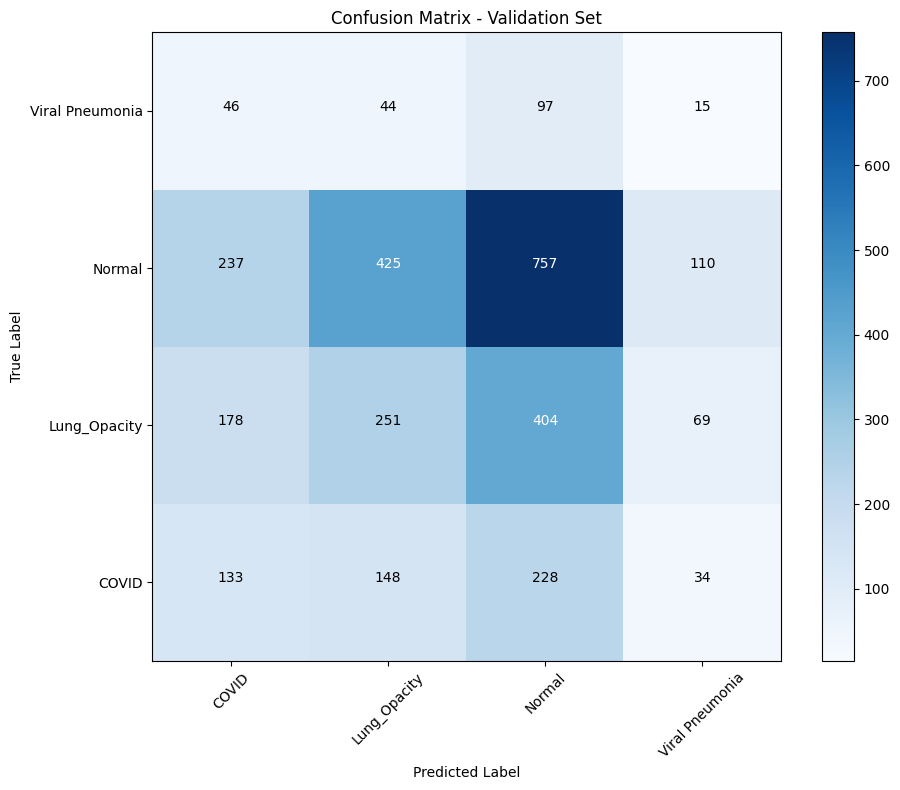


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.26      0.27      0.27       542
   Lung_Opacity       0.29      0.28      0.29       902
         Normal       0.51      0.50      0.51      1529
Viral Pneumonia       0.08      0.10      0.09       202

       accuracy                           0.37      3175
      macro avg       0.29      0.29      0.29      3175
   weighted avg       0.38      0.37      0.38      3175



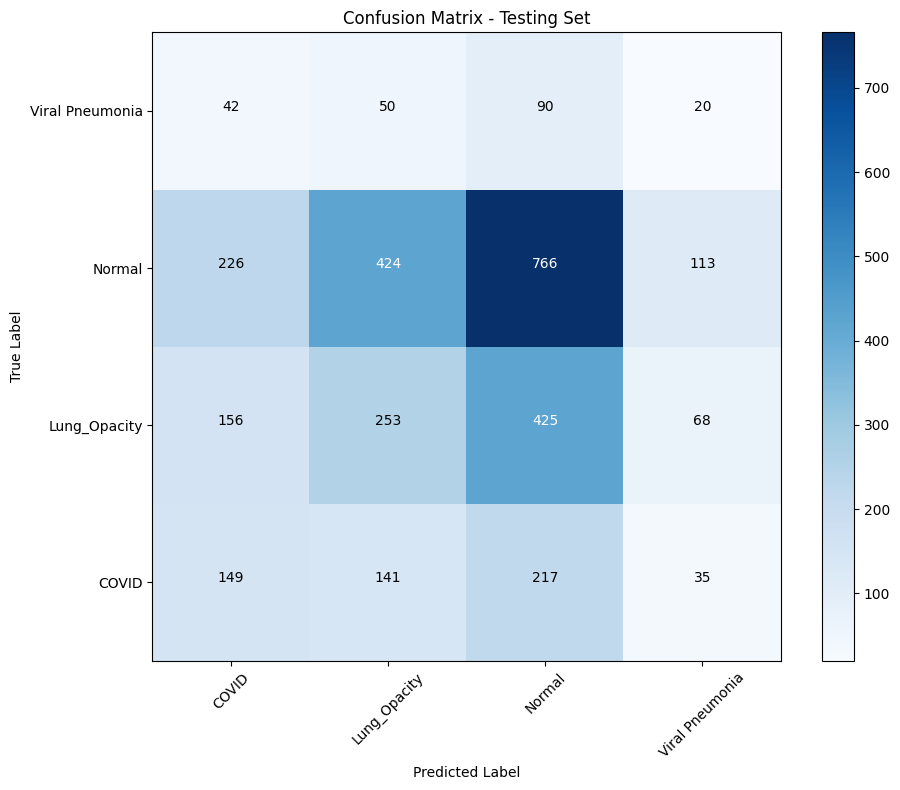

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = decision_tree.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = decision_tree.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```KNN```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.28      0.31      0.29       543
   Lung_Opacity       0.34      0.31      0.32       902
         Normal       0.55      0.62      0.59      1529
Viral Pneumonia       0.35      0.07      0.12       202

       accuracy                           0.44      3176
      macro avg       0.38      0.33      0.33      3176
   weighted avg       0.43      0.44      0.43      3176



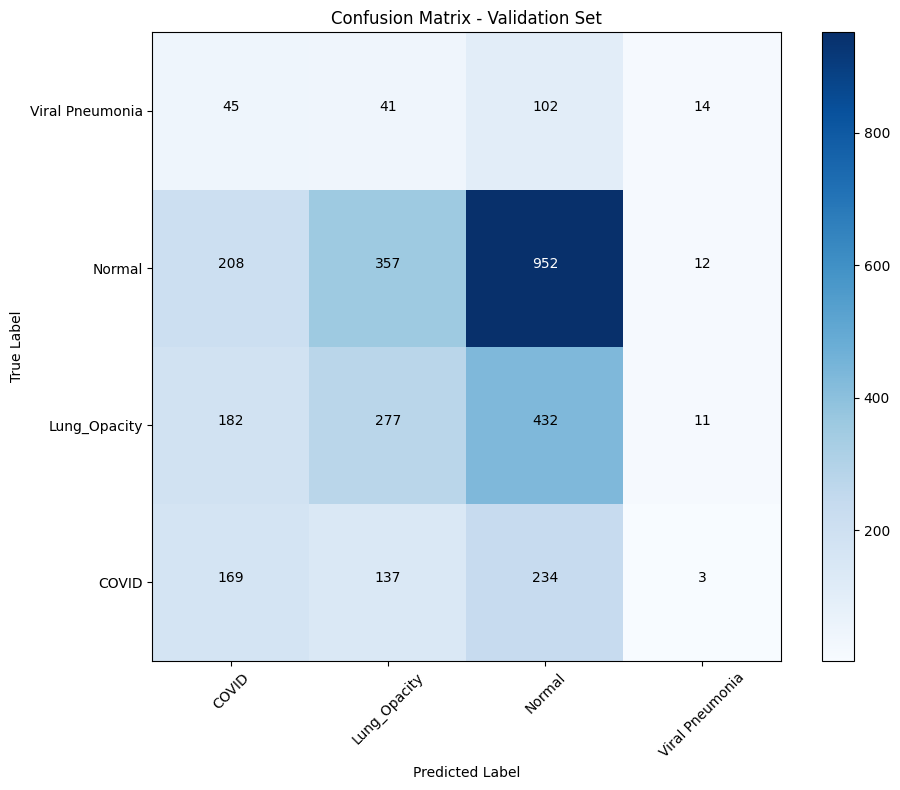


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.32      0.36      0.34       542
   Lung_Opacity       0.35      0.31      0.33       902
         Normal       0.55      0.61      0.58      1529
Viral Pneumonia       0.20      0.05      0.08       202

       accuracy                           0.45      3175
      macro avg       0.35      0.33      0.33      3175
   weighted avg       0.43      0.45      0.43      3175



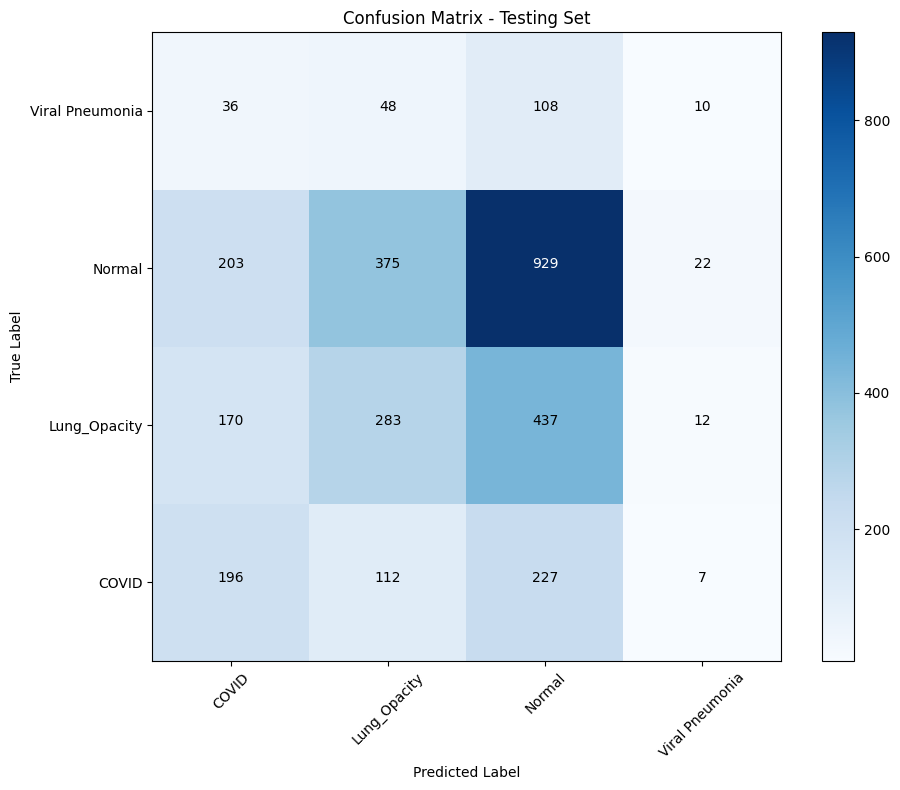

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
Knn_classifier = KNeighborsClassifier()
Knn_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = Knn_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = Knn_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Naive Bayes```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.27      0.35      0.30       543
   Lung_Opacity       0.41      0.18      0.25       902
         Normal       0.56      0.61      0.58      1529
Viral Pneumonia       0.16      0.34      0.22       202

       accuracy                           0.42      3176
      macro avg       0.35      0.37      0.34      3176
   weighted avg       0.44      0.42      0.42      3176



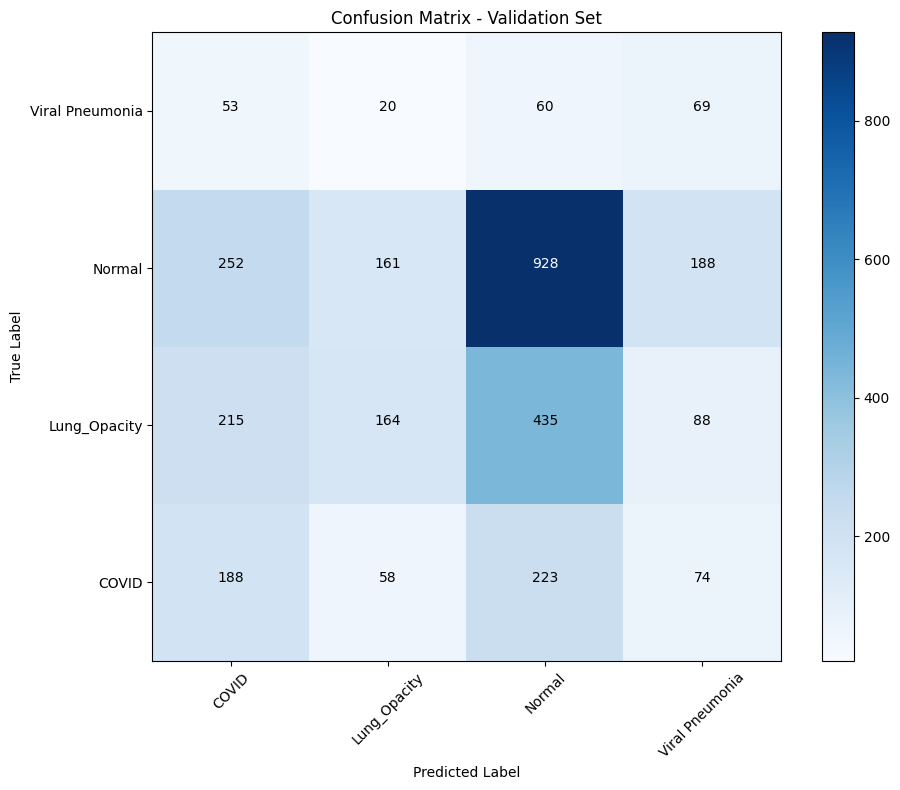


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.39      0.34       542
   Lung_Opacity       0.42      0.20      0.27       902
         Normal       0.55      0.58      0.57      1529
Viral Pneumonia       0.14      0.30      0.19       202

       accuracy                           0.42      3175
      macro avg       0.35      0.37      0.34      3175
   weighted avg       0.45      0.42      0.42      3175



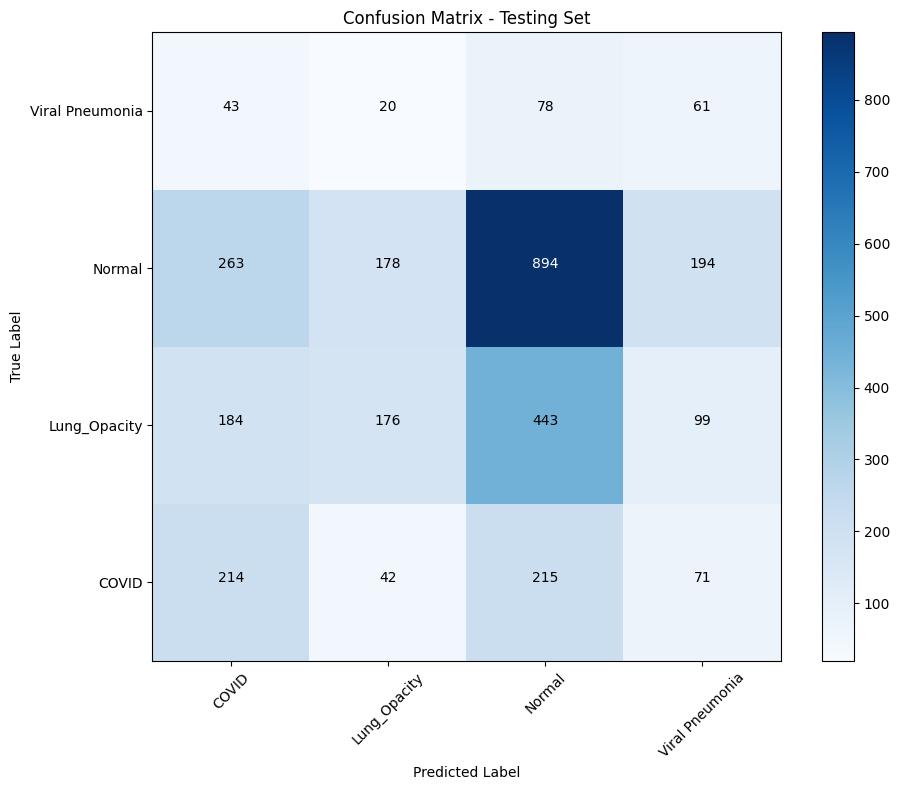

In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
NB_classifier = GaussianNB()
NB_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = NB_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = NB_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```SVM```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.41      0.18      0.25       543
   Lung_Opacity       0.46      0.14      0.22       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3176
      macro avg       0.35      0.31      0.28      3176
   weighted avg       0.45      0.51      0.42      3176



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

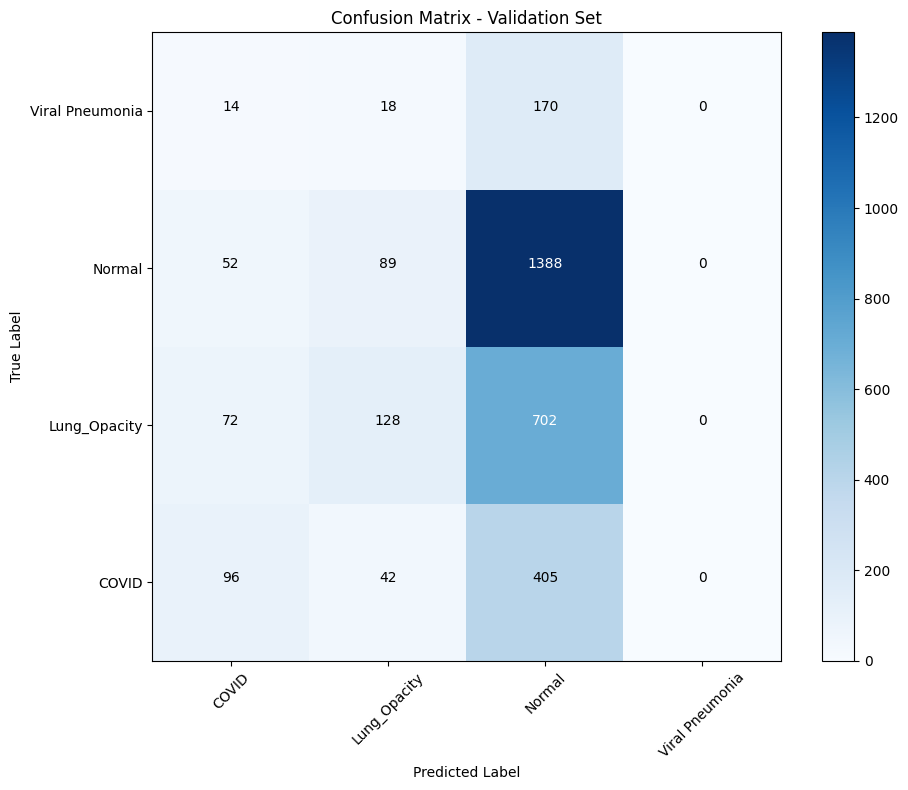


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.48      0.22      0.31       542
   Lung_Opacity       0.47      0.14      0.22       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3175
      macro avg       0.37      0.32      0.30      3175
   weighted avg       0.47      0.51      0.43      3175



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

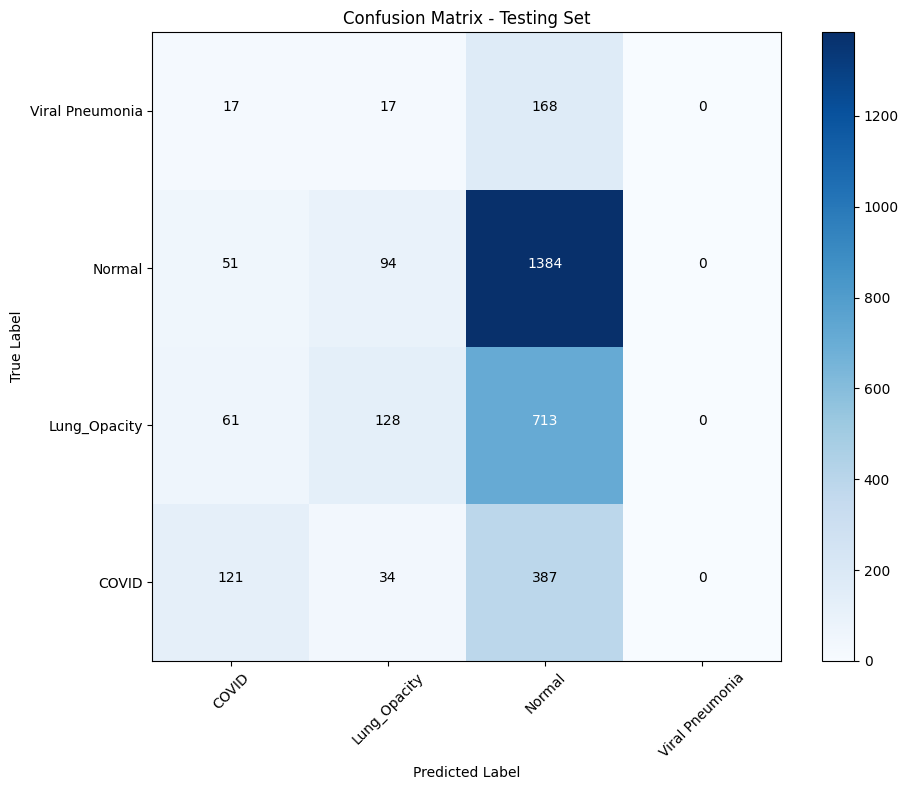

In [ ]:
from sklearn import svm

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = svm_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = svm_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Approach 3: Taking Largest Feature Vector```

In [87]:
def approach3_extract_orb_features(data, max_features):
    orb = cv2.ORB_create()
    orb_features = []
    for image in data:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()  # Flatten to make it 1D
            if len(descriptors) >= max_features:
                orb_features.append(descriptors[:max_features])
            else:
                # Append zeros to make up to max_features
                padded_descriptors = np.concatenate([descriptors, np.zeros(max_features - len(descriptors), dtype=np.float32)])
                orb_features.append(padded_descriptors)
        else:
            # If no descriptors found, append zeros
            orb_features.append(np.zeros(max_features, dtype=np.float32))
    return orb_features

##### ```Taking Max of Feature Vector lengths```

In [88]:
lengths_xtrainorb = []
for i in X_train_orb:
    lengths_xtrainorb.append(len(i))

In [89]:
max_val = max(lengths_xtrainorb)
max_val

488

#### **Model Implementation**

##### ```Decsion Tree```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.24      0.27      0.26       543
   Lung_Opacity       0.30      0.30      0.30       902
         Normal       0.53      0.51      0.52      1529
Viral Pneumonia       0.07      0.06      0.07       202

       accuracy                           0.38      3176
      macro avg       0.29      0.29      0.29      3176
   weighted avg       0.39      0.38      0.38      3176



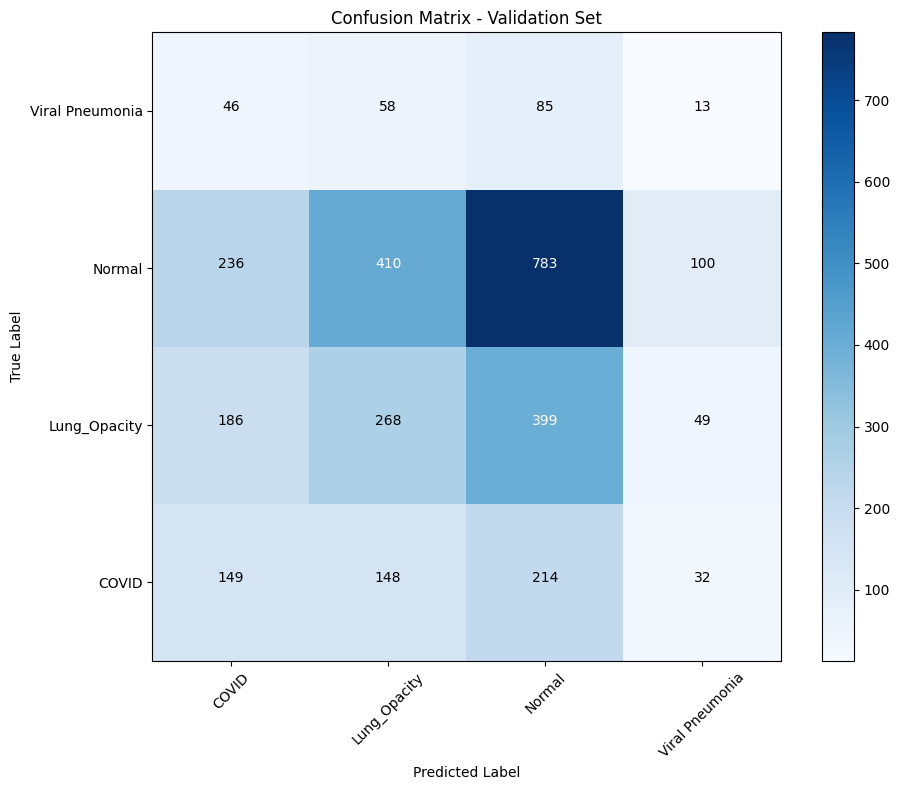


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.28      0.30      0.29       542
   Lung_Opacity       0.34      0.35      0.34       902
         Normal       0.54      0.52      0.53      1529
Viral Pneumonia       0.11      0.11      0.11       202

       accuracy                           0.41      3175
      macro avg       0.32      0.32      0.32      3175
   weighted avg       0.41      0.41      0.41      3175



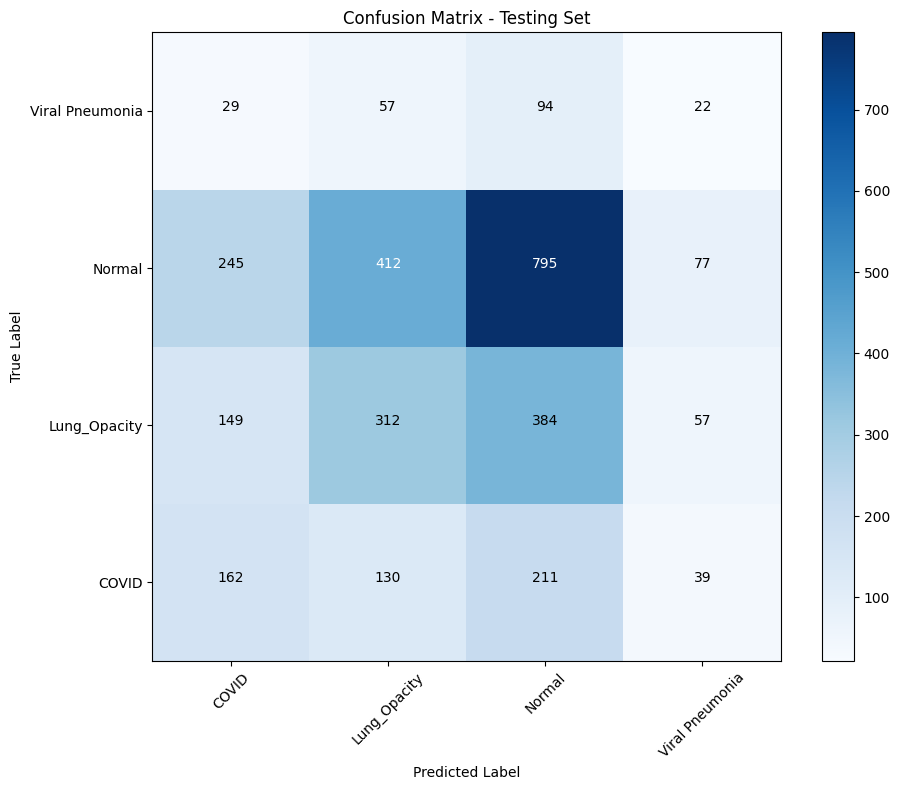

In [90]:
from sklearn.tree import DecisionTreeClassifier

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = decision_tree.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = decision_tree.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```KNN```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.41      0.34       543
   Lung_Opacity       0.35      0.38      0.36       902
         Normal       0.59      0.56      0.57      1529
Viral Pneumonia       0.38      0.04      0.07       202

       accuracy                           0.45      3176
      macro avg       0.41      0.35      0.34      3176
   weighted avg       0.46      0.45      0.44      3176



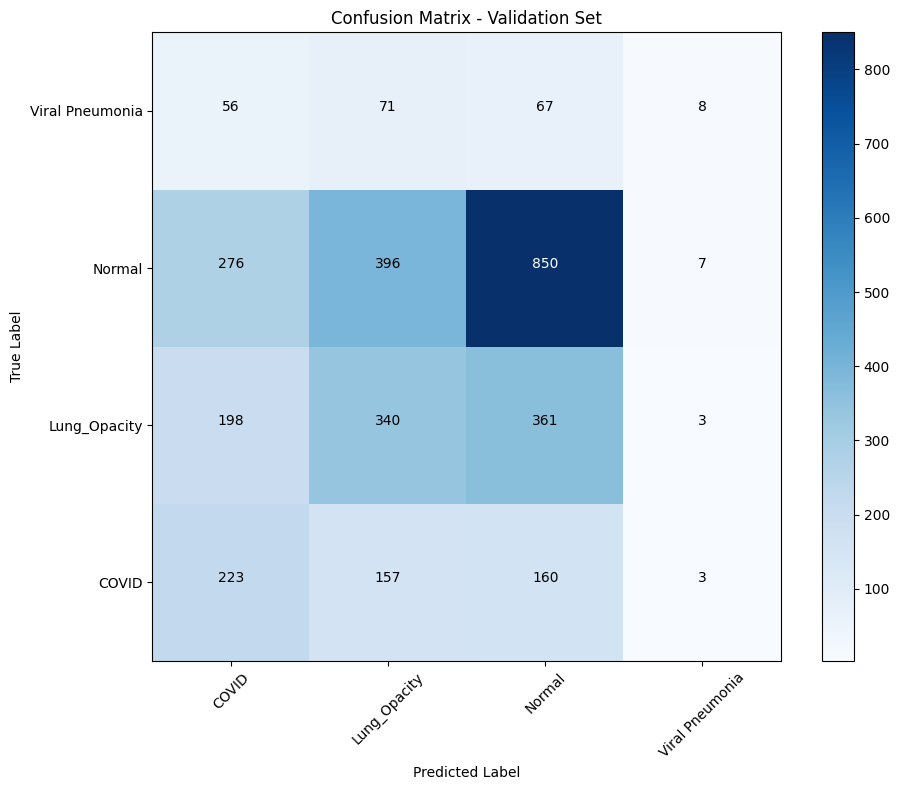


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.34      0.44      0.38       542
   Lung_Opacity       0.35      0.38      0.37       902
         Normal       0.59      0.58      0.58      1529
Viral Pneumonia       0.36      0.05      0.09       202

       accuracy                           0.46      3175
      macro avg       0.41      0.36      0.36      3175
   weighted avg       0.47      0.46      0.46      3175



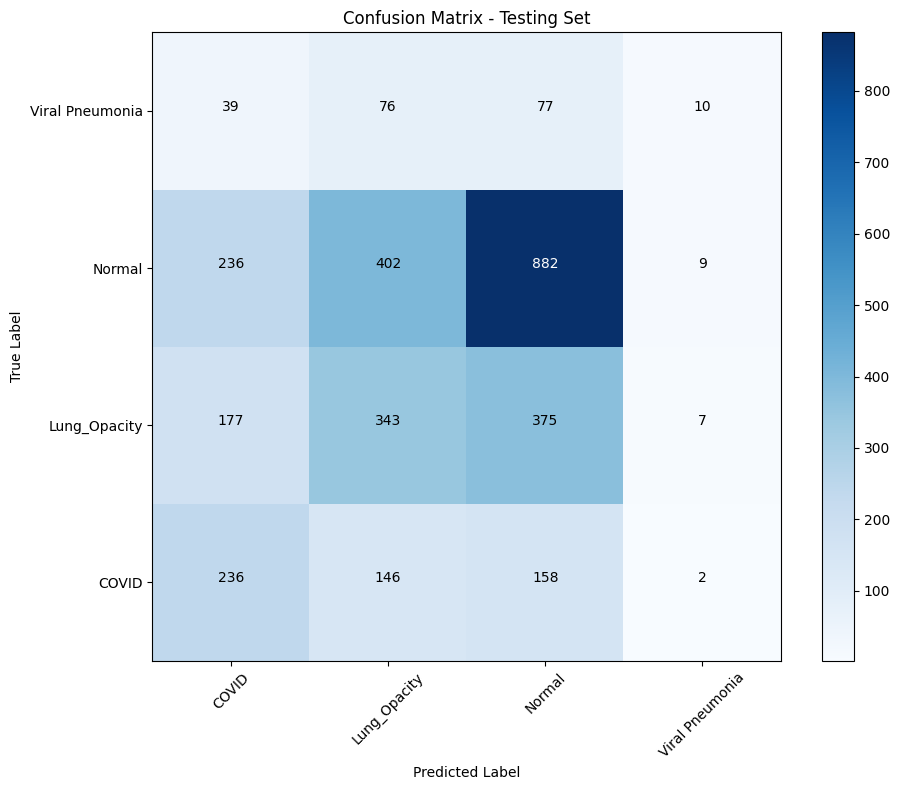

In [91]:
from sklearn.neighbors import KNeighborsClassifier

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
Knn_classifier = KNeighborsClassifier()
Knn_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = Knn_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = Knn_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Naive Bayes```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.18      0.22       543
   Lung_Opacity       0.45      0.09      0.15       902
         Normal       0.55      0.80      0.65      1529
Viral Pneumonia       0.25      0.52      0.33       202

       accuracy                           0.48      3176
      macro avg       0.39      0.40      0.34      3176
   weighted avg       0.46      0.48      0.42      3176



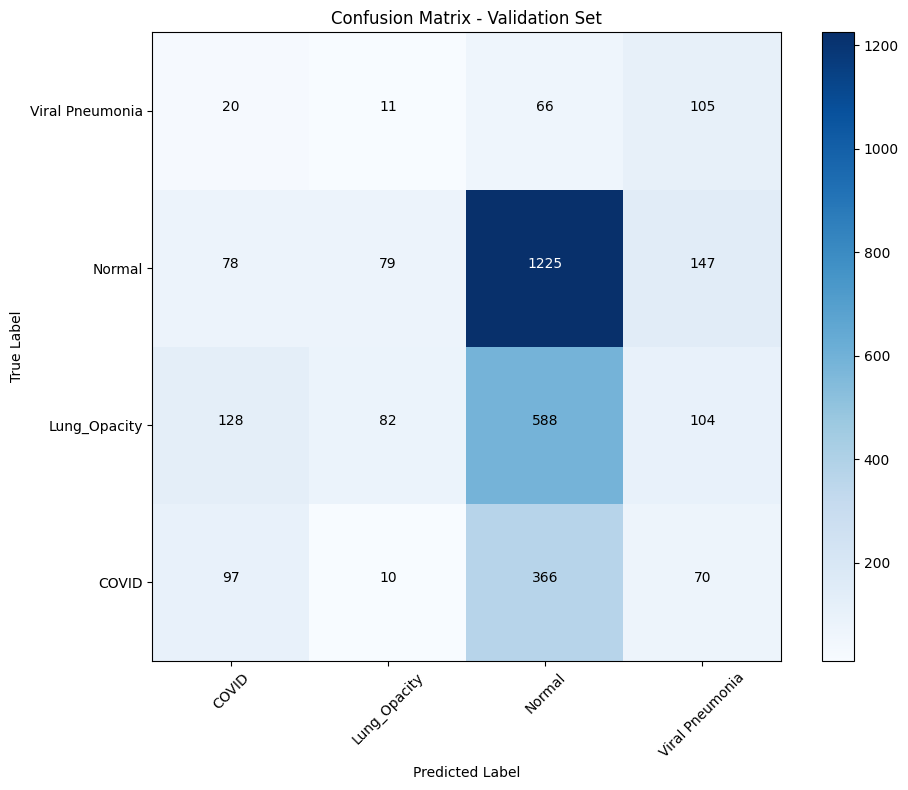


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.33      0.19      0.24       542
   Lung_Opacity       0.45      0.11      0.18       902
         Normal       0.54      0.79      0.64      1529
Viral Pneumonia       0.20      0.41      0.27       202

       accuracy                           0.47      3175
      macro avg       0.38      0.37      0.33      3175
   weighted avg       0.46      0.47      0.42      3175



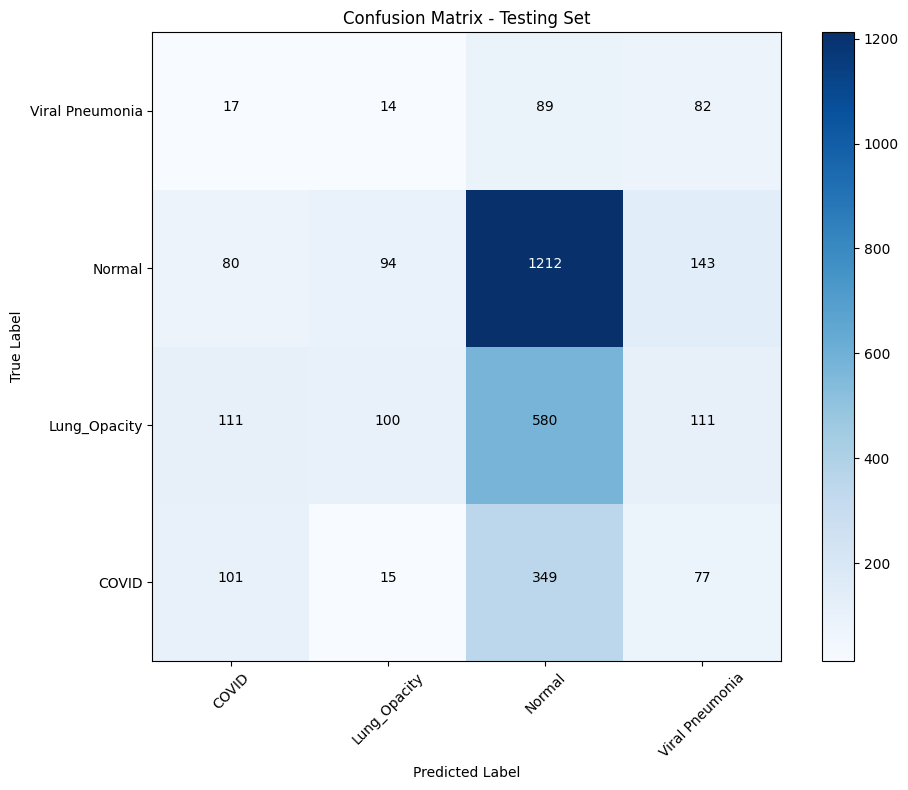

In [92]:
from sklearn.naive_bayes import GaussianNB

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
NB_classifier = GaussianNB()
NB_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = NB_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = NB_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```SVM```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.40      0.21      0.27       543
   Lung_Opacity       0.47      0.23      0.31       902
         Normal       0.54      0.87      0.66      1529
Viral Pneumonia       1.00      0.01      0.02       202

       accuracy                           0.52      3176
      macro avg       0.60      0.33      0.32      3176
   weighted avg       0.52      0.52      0.46      3176



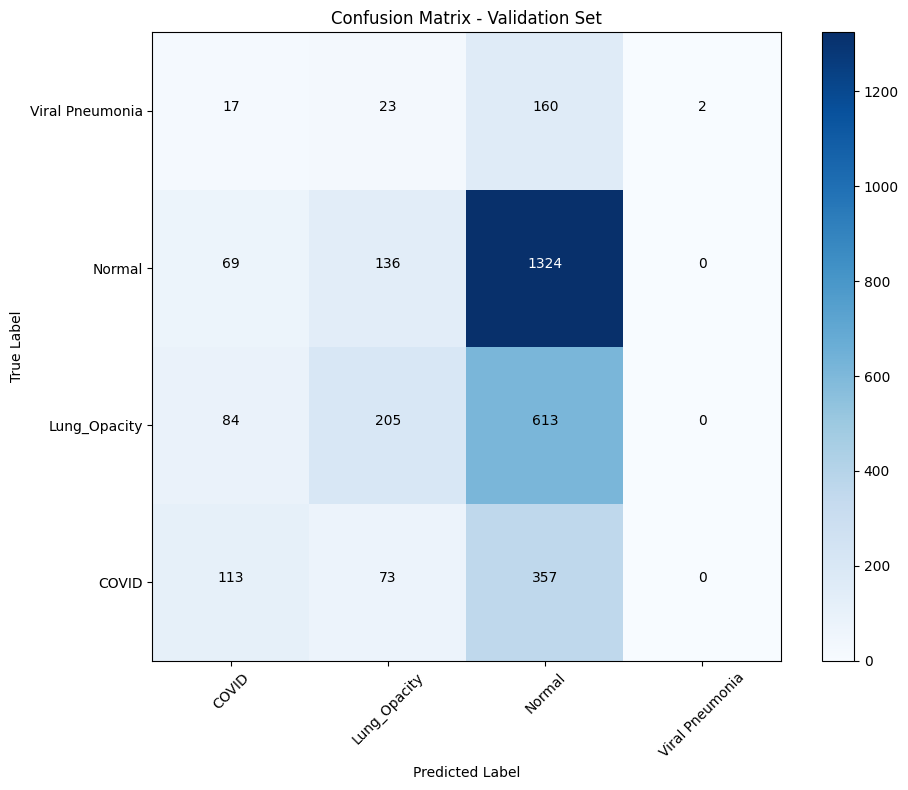


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.51      0.26      0.34       542
   Lung_Opacity       0.48      0.22      0.30       902
         Normal       0.54      0.88      0.67      1529
Viral Pneumonia       1.00      0.01      0.02       202

       accuracy                           0.53      3175
      macro avg       0.63      0.34      0.33      3175
   weighted avg       0.55      0.53      0.47      3175



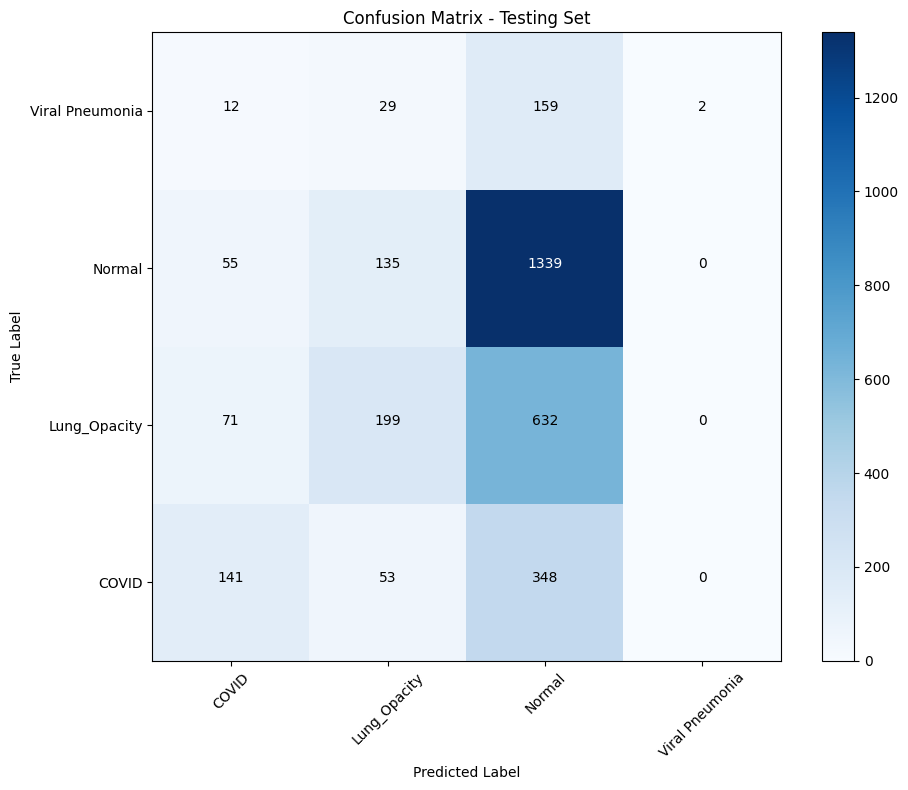

In [93]:
from sklearn import svm

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = svm_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = svm_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

### **SIFT**

In [137]:
def approach1_extract_sift_features(data, max_features):
    sift_features = []
    sift = cv2.SIFT_create()
    for image in data:
        keypoints, descriptors = sift.detectAndCompute(image, None)
        if descriptors is not None:
            if len(descriptors) >= max_features:
                sift_features.append(descriptors[:max_features])
            else:
                # Append zeros to make up to max_features
                padded_descriptors = np.concatenate([descriptors, np.zeros((max_features - len(descriptors), descriptors.shape[1]), dtype=np.float32)])
                sift_features.append(padded_descriptors)
        else:
            # If no descriptors found, append zeros
            sift_features.append(np.zeros((max_features, 128), dtype=np.float32))  # Assuming each descriptor has 128 dimensions
    return sift_features

sift_X_train = approach1_extract_sift_features(X_train, 100)

In [138]:
sift_X_train = approach1_extract_sift_features(X_train, 100)

In [139]:
lengths_xtrainsift = []
for i in sift_X_train:
    lengths_xtrainorb.append(len(i))

##### ```ORB Feature lengths distribution Visualization```

The reason for doing that is here we can know about using the two main approaches
* ```Approach 1: Most Frequently Occuring (MODE)``` : Checking up on common lengths of features using the distribution graph to get a number from there and truncate all other features after that number (to make equal features to pass them to a model) 
* ```Approach 2: Taking Average (MEAN)``` : Taking avg or mean value using feature lengths and truncate all other features after that number (to make equal features to pass them to a model) 
* ```Approach 3: Taking Largest Feature Vector``` : Taking largest feature vector length and add zeros to remaining feature vectors (to make equal features to pass them to a model) 

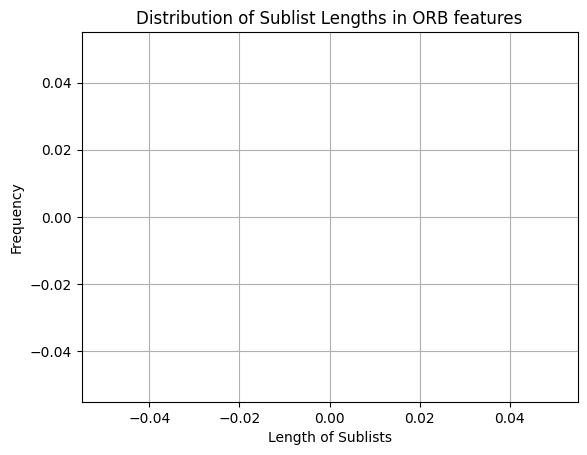

In [141]:
import matplotlib.pyplot as plt

# Get the lengths of the sublists in X_train
lengths = [len(sublist) for sublist in sift_X_train]

# Plot the distribution of counts
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1), edgecolor='black')
plt.xlabel('Length of Sublists')
plt.ylabel('Frequency')
plt.title('Distribution of Sublist Lengths in ORB features')
plt.grid(True)
plt.show()

In [ ]:
# Flatten the features
# X_train_orb_flat = np.array([descriptor for sublist in X_train_orb for descriptor in sublist])

##### ```ORB Feature Keypoints Visualization```

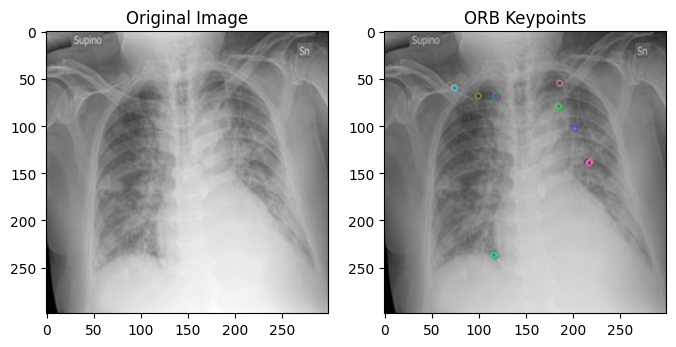

In [ ]:
# Load first Image from X_train
image = X_train[0]

# Extract ORB features
orb = cv2.ORB_create()
keypoints, orb_image = orb.detectAndCompute(image, None)

Image_keypoint1 = cv2.drawKeypoints(image, keypoints, None)

# Plot both images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# Display original image
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')

# Draw keypoints on the original image
# cv2.drawKeypoints(image, Image_keypoint1, image, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
ax2.imshow(Image_keypoint1, cmap='gray')
ax2.set_title('ORB Keypoints')

plt.show()

##### ```Approach 1: Most Frequently Occuring (MODE)```

In [ ]:
def approach1_extract_orb_features(data, max_features):
    orb = cv2.ORB_create()
    orb_features = []
    for image in data:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()  # Flatten to make it 1D
            if len(descriptors) >= max_features:
                orb_features.append(descriptors[:max_features])
            else:
                # Append zeros to make up to max_features
                padded_descriptors = np.concatenate([descriptors, np.zeros(max_features - len(descriptors), dtype=np.float32)])
                orb_features.append(padded_descriptors)
        else:
            # If no descriptors found, append zeros
            orb_features.append(np.zeros(max_features, dtype=np.float32))
    return orb_features

##### ```Taking Most Frequent Feature Vector Lengths (MODE)```

In [ ]:
lengths_xtrainorb = []
for i in X_train_orb:
    lengths_xtrainorb.append(len(i))

In [ ]:
import statistics

# Find the mode
mode_length = statistics.mode(lengths_xtrainorb)

# Check if mode is less than 20
if mode_length < 20:
    # Calculate frequencies of each value
    freq_dict = {x: lengths_xtrainorb.count(x) for x in set(lengths_xtrainorb)}
    # Sort frequencies in descending order
    sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
    # Find the next frequent value with a length of 20 or greater
    for length, freq in sorted_freq:
        if length >= 20:
            mode_length = length
            break

print("Mode (most frequent length):", mode_length)

Mode (most frequent length): 120


#### **Model Implementation**

##### ```Decsion Tree```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.25      0.26      0.26       543
   Lung_Opacity       0.28      0.27      0.28       902
         Normal       0.51      0.49      0.50      1529
Viral Pneumonia       0.10      0.12      0.11       202

       accuracy                           0.37      3176
      macro avg       0.28      0.29      0.29      3176
   weighted avg       0.37      0.37      0.37      3176



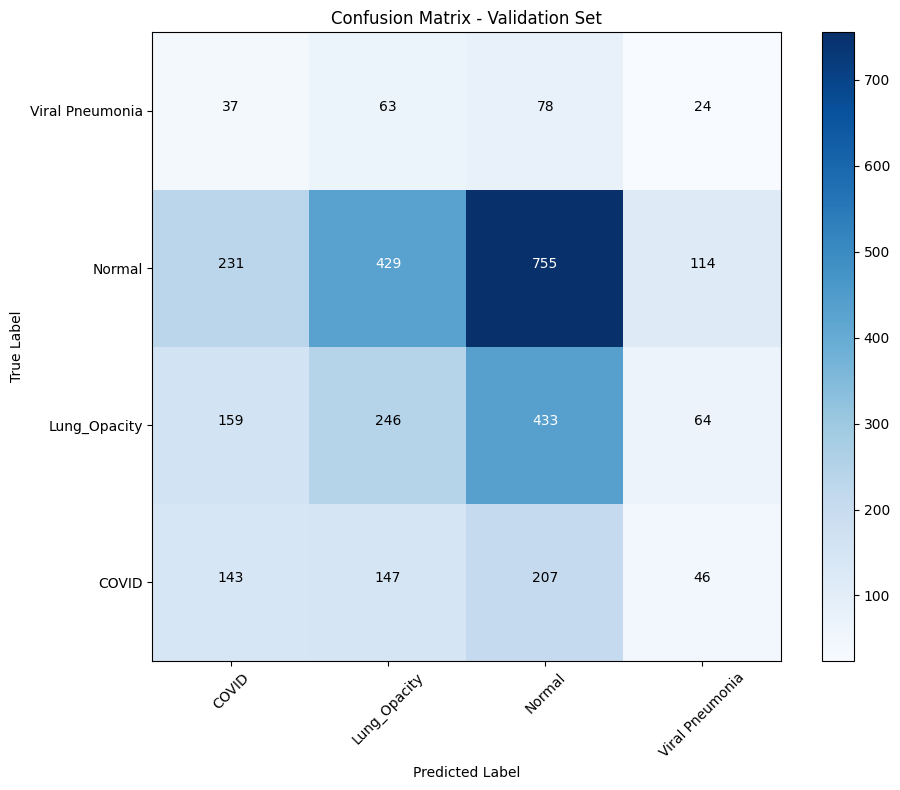


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.27      0.29      0.28       542
   Lung_Opacity       0.32      0.32      0.32       902
         Normal       0.52      0.50      0.51      1529
Viral Pneumonia       0.08      0.09      0.09       202

       accuracy                           0.39      3175
      macro avg       0.30      0.30      0.30      3175
   weighted avg       0.39      0.39      0.39      3175



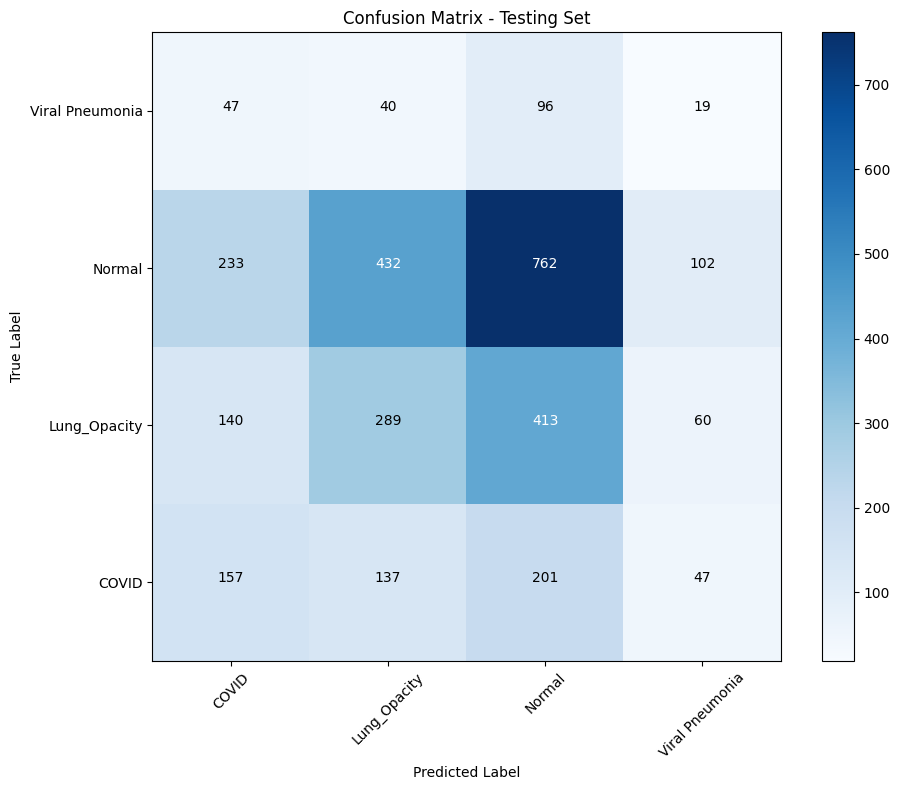

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = decision_tree.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = decision_tree.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```KNN```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.31      0.34      0.32       543
   Lung_Opacity       0.35      0.30      0.33       902
         Normal       0.55      0.63      0.58      1529
Viral Pneumonia       0.21      0.03      0.06       202

       accuracy                           0.45      3176
      macro avg       0.35      0.33      0.32      3176
   weighted avg       0.43      0.45      0.43      3176



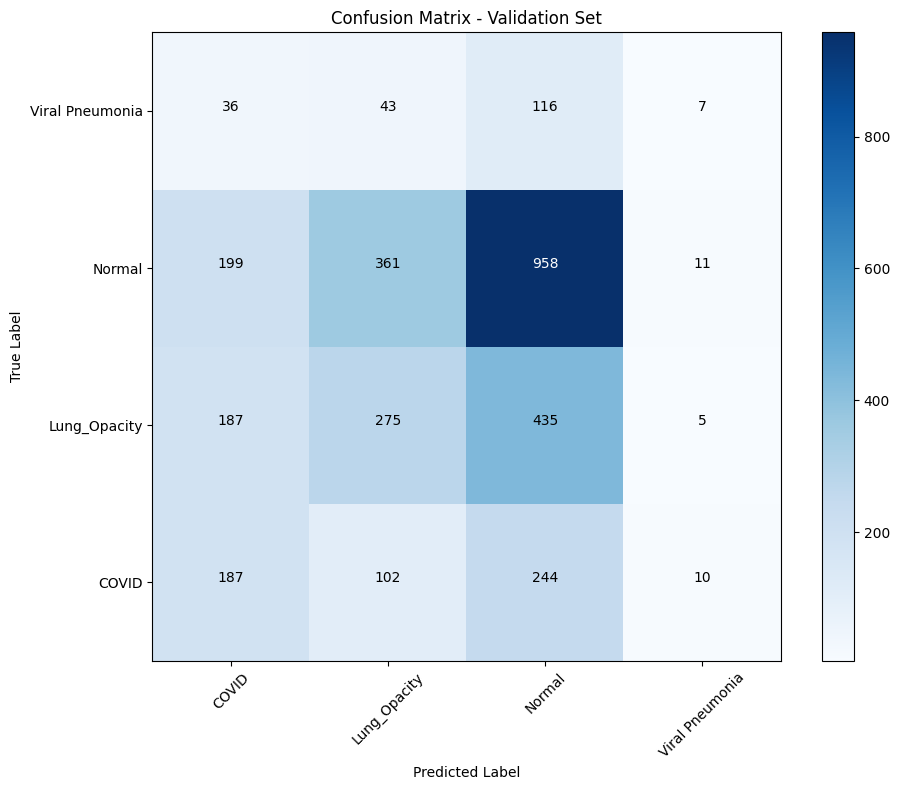


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.29      0.35      0.32       542
   Lung_Opacity       0.37      0.33      0.35       902
         Normal       0.55      0.61      0.58      1529
Viral Pneumonia       0.17      0.03      0.06       202

       accuracy                           0.45      3175
      macro avg       0.35      0.33      0.32      3175
   weighted avg       0.43      0.45      0.43      3175



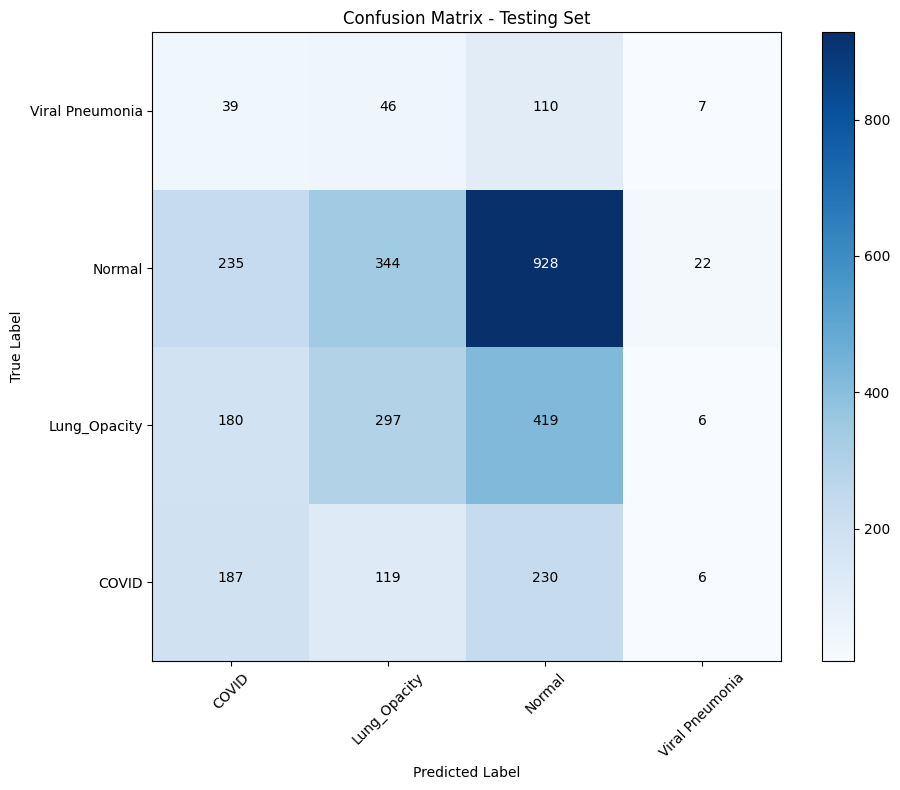

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
Knn_classifier = KNeighborsClassifier()
Knn_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = Knn_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = Knn_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Naive Bayes```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.27      0.34      0.30       543
   Lung_Opacity       0.42      0.19      0.26       902
         Normal       0.55      0.61      0.58      1529
Viral Pneumonia       0.15      0.31      0.20       202

       accuracy                           0.42      3176
      macro avg       0.35      0.36      0.33      3176
   weighted avg       0.44      0.42      0.42      3176



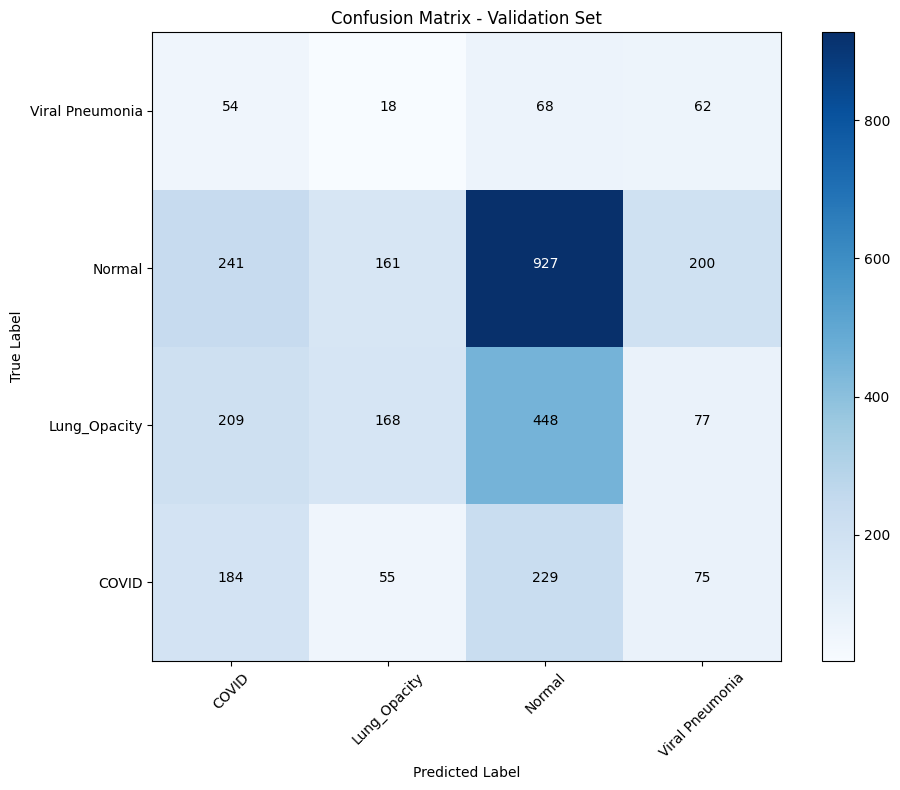


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.41      0.35       542
   Lung_Opacity       0.40      0.18      0.25       902
         Normal       0.55      0.59      0.56      1529
Viral Pneumonia       0.13      0.25      0.17       202

       accuracy                           0.42      3175
      macro avg       0.34      0.36      0.33      3175
   weighted avg       0.44      0.42      0.41      3175



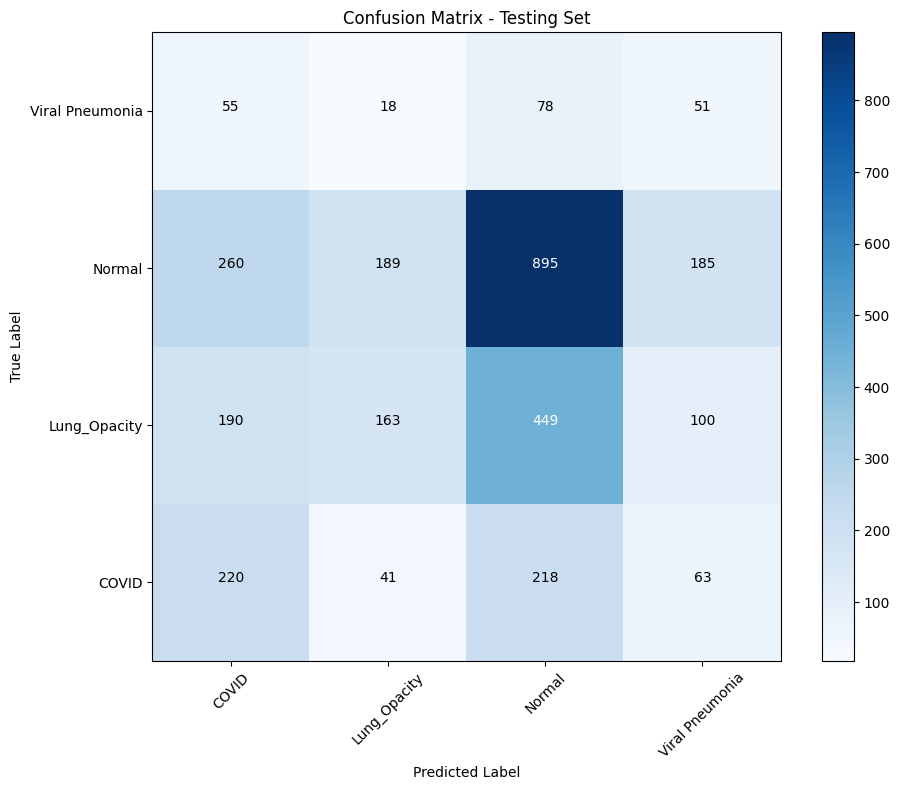

In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
NB_classifier = GaussianNB()
NB_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = NB_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = NB_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```SVM```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.40      0.17      0.23       543
   Lung_Opacity       0.48      0.14      0.21       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3176
      macro avg       0.35      0.30      0.28      3176
   weighted avg       0.45      0.51      0.42      3176



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

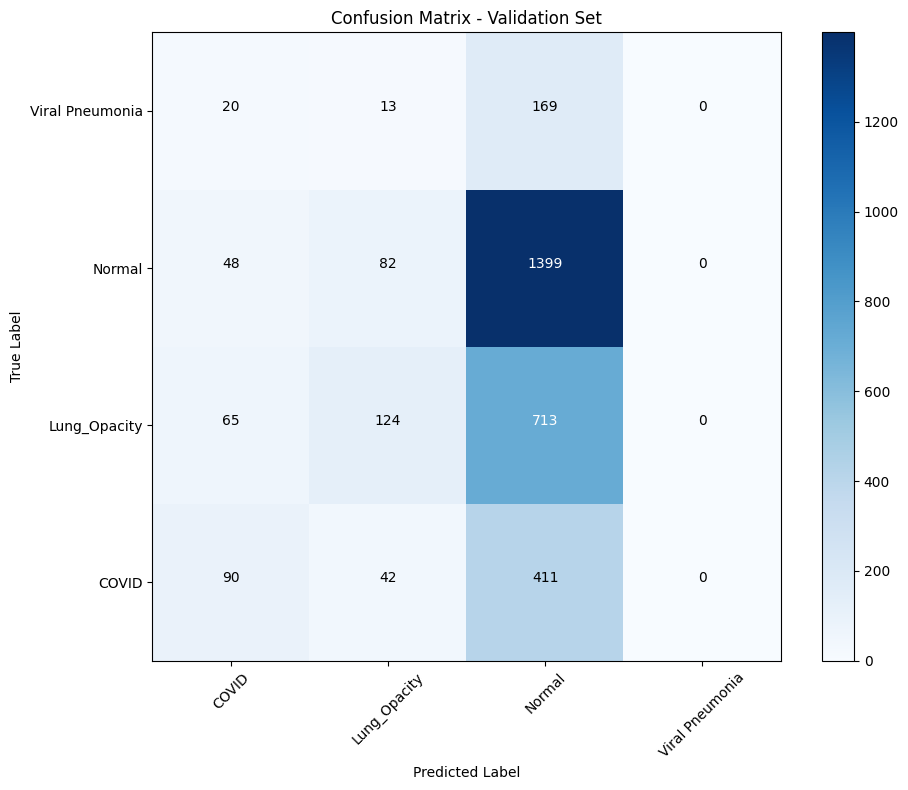


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.48      0.20      0.29       542
   Lung_Opacity       0.47      0.14      0.22       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3175
      macro avg       0.37      0.31      0.29      3175
   weighted avg       0.47      0.51      0.43      3175



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

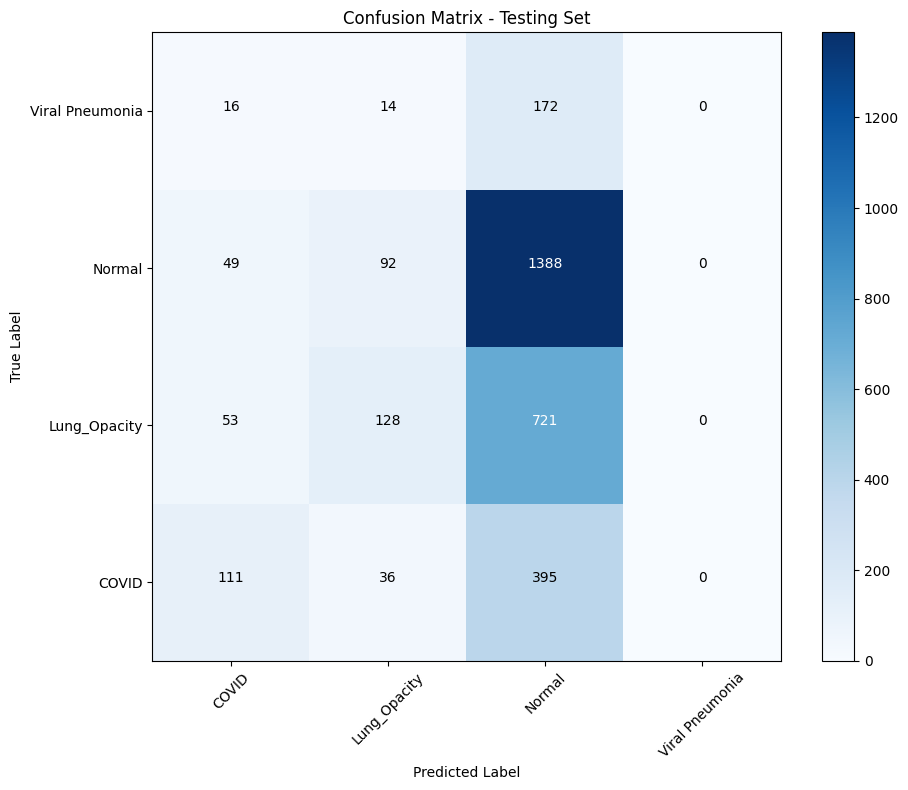

In [ ]:
from sklearn import svm

X_train_orb = approach1_extract_orb_features(X_train,mode_length)

# Train a Model
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach1_extract_orb_features(X_val,mode_length)

# Evaluate Model on Validation Set
val_predictions = svm_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach1_extract_orb_features(X_test,mode_length)

# Evaluate Model on Testing Set
test_predictions = svm_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Approach 2: Taking Average (MEAN)```

In [ ]:
def approach2_extract_orb_features(data, max_features):
    orb = cv2.ORB_create()
    orb_features = []
    for image in data:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()  # Flatten to make it 1D
            if len(descriptors) >= max_features:
                orb_features.append(descriptors[:max_features])
            else:
                # Append zeros to make up to max_features
                padded_descriptors = np.concatenate([descriptors, np.zeros(max_features - len(descriptors), dtype=np.float32)])
                orb_features.append(padded_descriptors)
        else:
            # If no descriptors found, append zeros
            orb_features.append(np.zeros(max_features, dtype=np.float32))
    return orb_features

##### ```Taking Average of Feature Vector lengths```

In [ ]:
lengths_xtrainorb = []
for i in X_train_orb:
    lengths_xtrainorb.append(len(i))

In [ ]:
def calculate_average(lst):
    if not lst:
        return 0  # Return 0 if the list is empty to avoid division by zero
    return sum(lst) / len(lst)

avg = calculate_average(lengths_xtrainorb)
print("Average:", avg)
avg = int(avg)
print("Average in Integer:", avg)

Average: 155.95814769812338
Average in Integer: 155


#### **Model Implementation**

##### ```Decsion Tree```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.22      0.24      0.23       543
   Lung_Opacity       0.29      0.28      0.28       902
         Normal       0.51      0.50      0.50      1529
Viral Pneumonia       0.07      0.07      0.07       202

       accuracy                           0.36      3176
      macro avg       0.27      0.27      0.27      3176
   weighted avg       0.37      0.36      0.37      3176



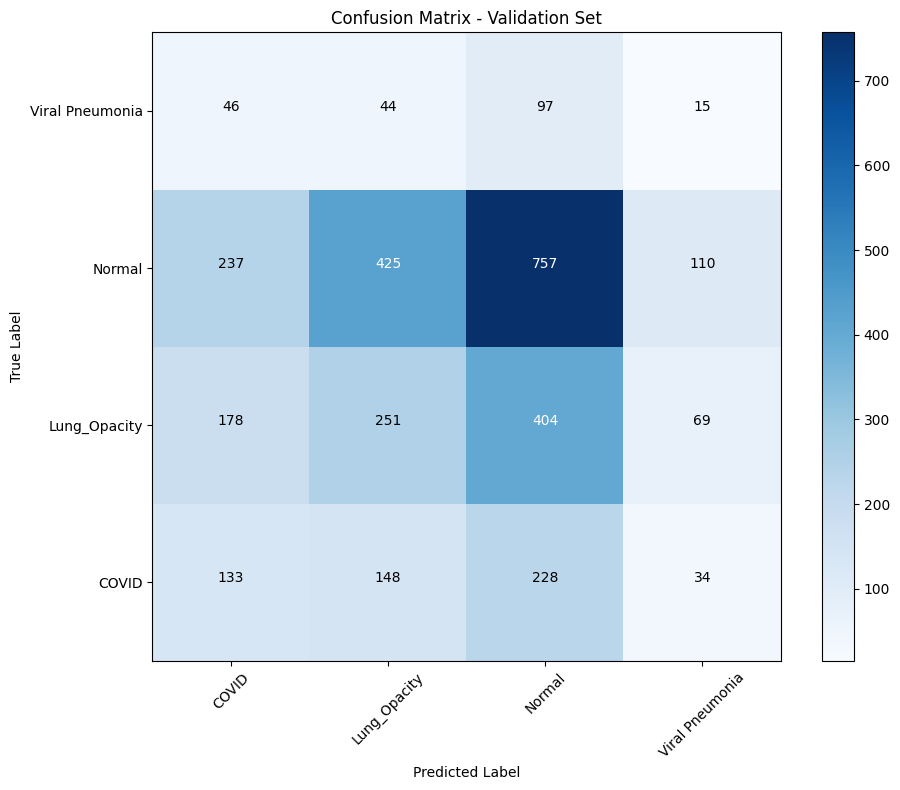


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.26      0.27      0.27       542
   Lung_Opacity       0.29      0.28      0.29       902
         Normal       0.51      0.50      0.51      1529
Viral Pneumonia       0.08      0.10      0.09       202

       accuracy                           0.37      3175
      macro avg       0.29      0.29      0.29      3175
   weighted avg       0.38      0.37      0.38      3175



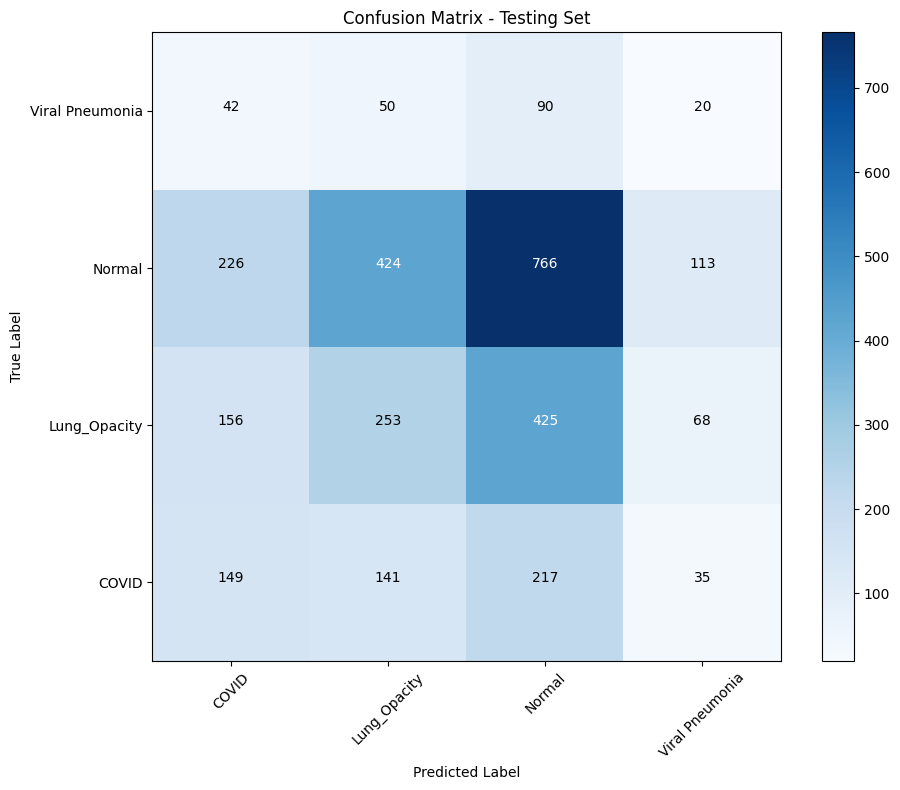

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = decision_tree.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = decision_tree.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```KNN```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.28      0.31      0.29       543
   Lung_Opacity       0.34      0.31      0.32       902
         Normal       0.55      0.62      0.59      1529
Viral Pneumonia       0.35      0.07      0.12       202

       accuracy                           0.44      3176
      macro avg       0.38      0.33      0.33      3176
   weighted avg       0.43      0.44      0.43      3176



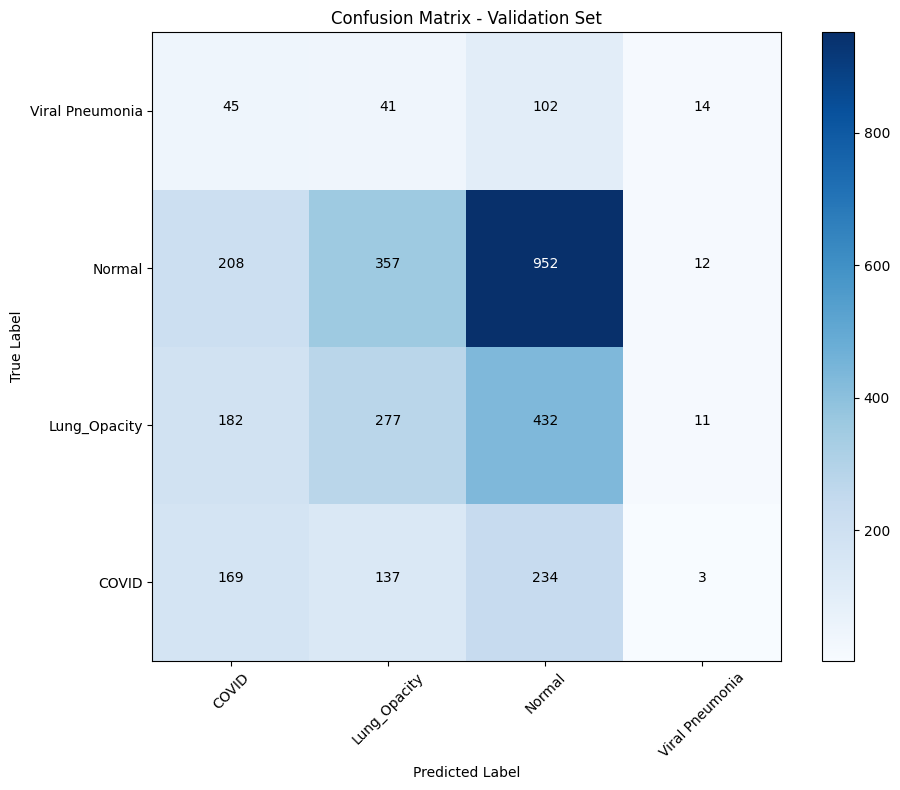


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.32      0.36      0.34       542
   Lung_Opacity       0.35      0.31      0.33       902
         Normal       0.55      0.61      0.58      1529
Viral Pneumonia       0.20      0.05      0.08       202

       accuracy                           0.45      3175
      macro avg       0.35      0.33      0.33      3175
   weighted avg       0.43      0.45      0.43      3175



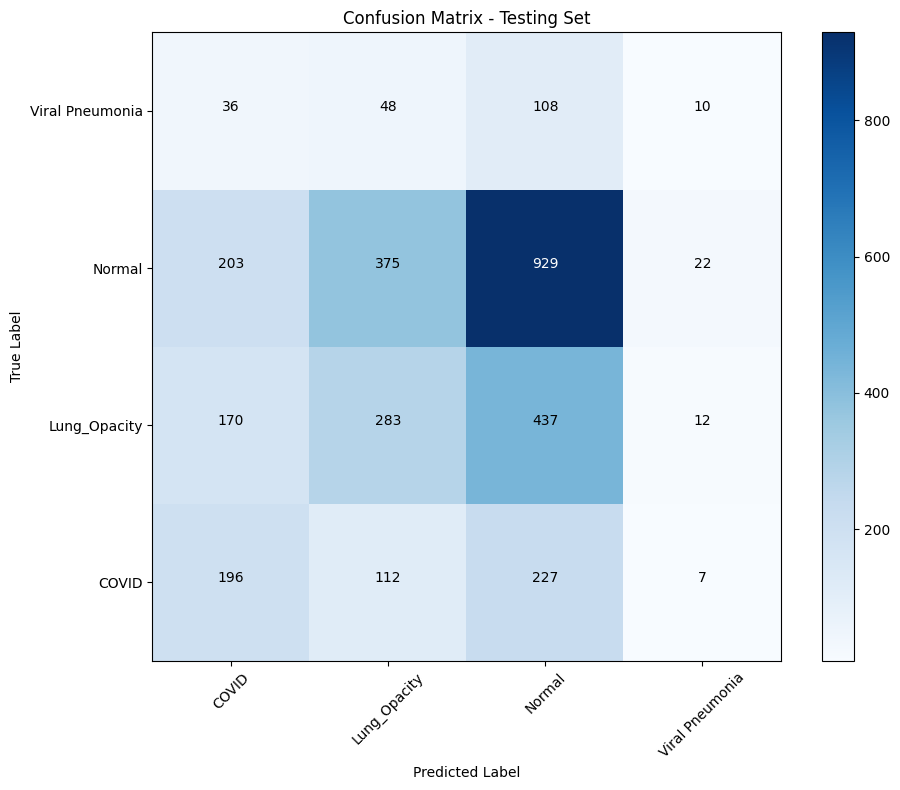

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
Knn_classifier = KNeighborsClassifier()
Knn_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = Knn_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = Knn_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Naive Bayes```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.27      0.35      0.30       543
   Lung_Opacity       0.41      0.18      0.25       902
         Normal       0.56      0.61      0.58      1529
Viral Pneumonia       0.16      0.34      0.22       202

       accuracy                           0.42      3176
      macro avg       0.35      0.37      0.34      3176
   weighted avg       0.44      0.42      0.42      3176



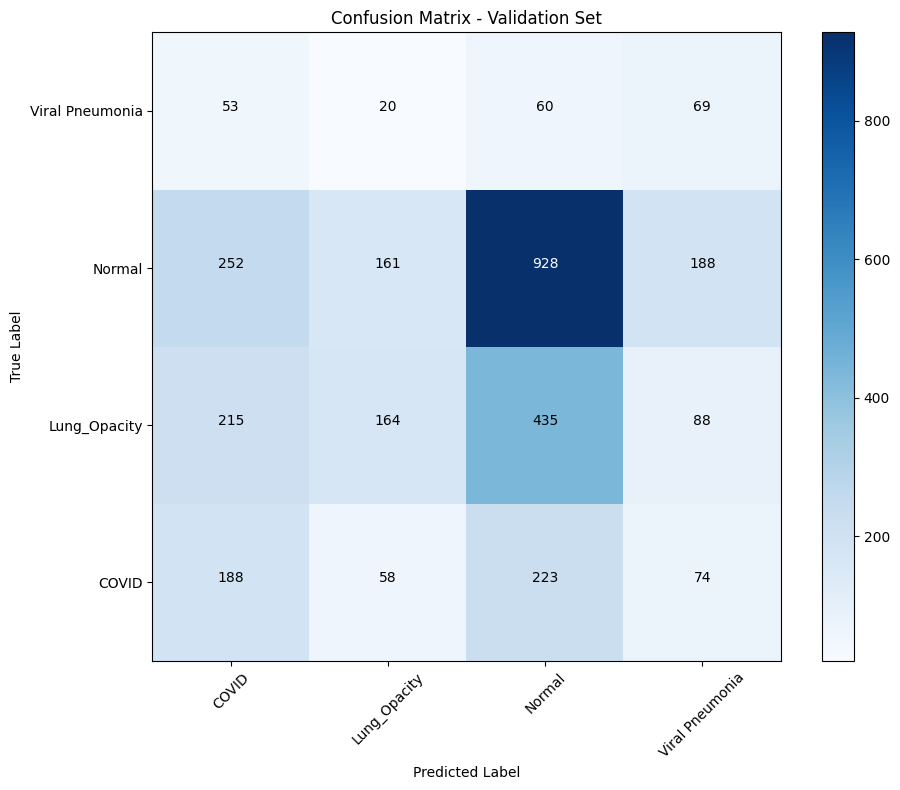


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.39      0.34       542
   Lung_Opacity       0.42      0.20      0.27       902
         Normal       0.55      0.58      0.57      1529
Viral Pneumonia       0.14      0.30      0.19       202

       accuracy                           0.42      3175
      macro avg       0.35      0.37      0.34      3175
   weighted avg       0.45      0.42      0.42      3175



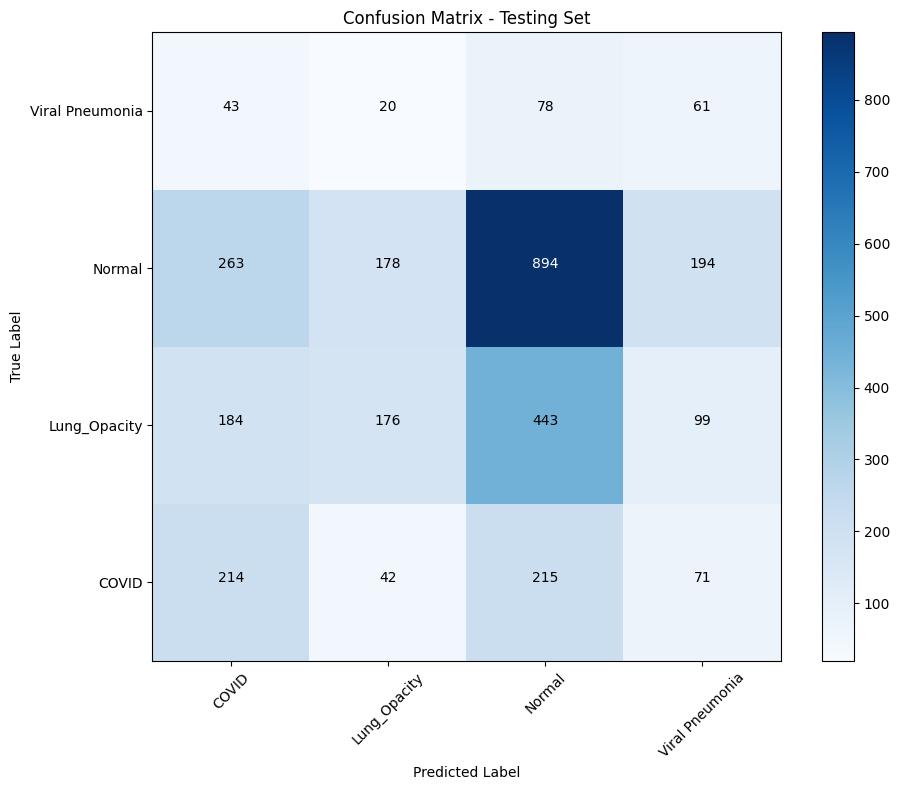

In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
NB_classifier = GaussianNB()
NB_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = NB_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = NB_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```SVM```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.41      0.18      0.25       543
   Lung_Opacity       0.46      0.14      0.22       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3176
      macro avg       0.35      0.31      0.28      3176
   weighted avg       0.45      0.51      0.42      3176



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

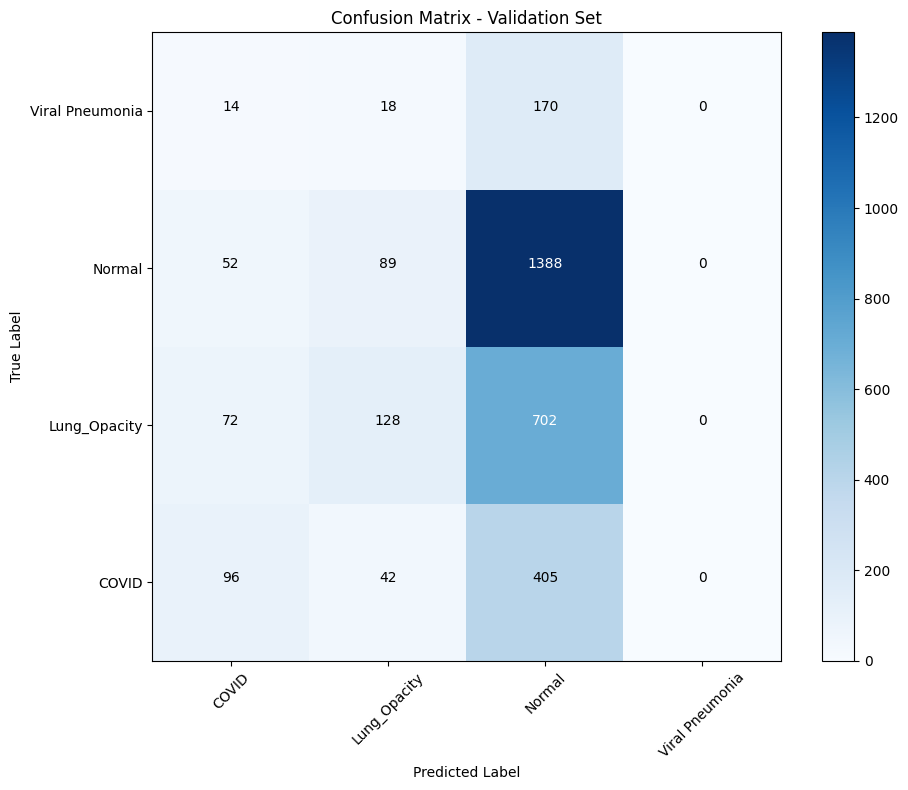


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.48      0.22      0.31       542
   Lung_Opacity       0.47      0.14      0.22       902
         Normal       0.52      0.91      0.66      1529
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.51      3175
      macro avg       0.37      0.32      0.30      3175
   weighted avg       0.47      0.51      0.43      3175



e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\My Projects\AI-ML\Vision\Covid-19 Classification\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

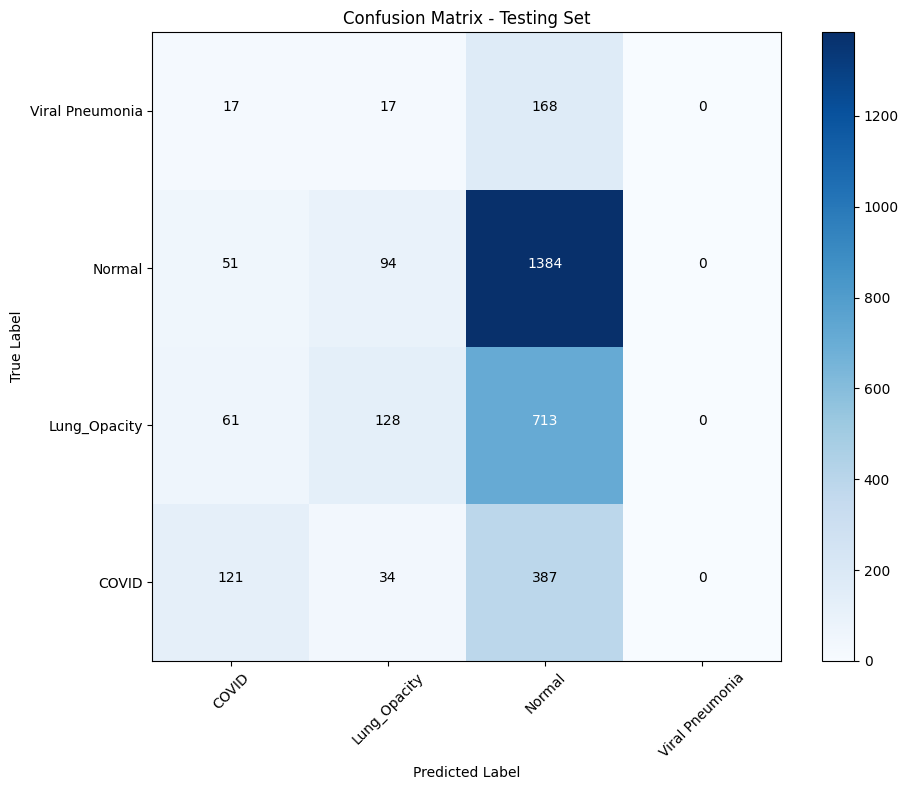

In [ ]:
from sklearn import svm

X_train_orb = approach2_extract_orb_features(X_train,avg)

# Train a Model
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach2_extract_orb_features(X_val,avg)

# Evaluate Model on Validation Set
val_predictions = svm_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach2_extract_orb_features(X_test,avg)

# Evaluate Model on Testing Set
test_predictions = svm_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Approach 3: Taking Largest Feature Vector```

In [ ]:
def approach3_extract_orb_features(data, max_features):
    orb = cv2.ORB_create()
    orb_features = []
    for image in data:
        keypoints, descriptors = orb.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors = descriptors.flatten()  # Flatten to make it 1D
            if len(descriptors) >= max_features:
                orb_features.append(descriptors[:max_features])
            else:
                # Append zeros to make up to max_features
                padded_descriptors = np.concatenate([descriptors, np.zeros(max_features - len(descriptors), dtype=np.float32)])
                orb_features.append(padded_descriptors)
        else:
            # If no descriptors found, append zeros
            orb_features.append(np.zeros(max_features, dtype=np.float32))
    return orb_features

##### ```Taking Max of Feature Vector lengths```

In [ ]:
lengths_xtrainorb = []
for i in X_train_orb:
    lengths_xtrainorb.append(len(i))

In [ ]:
max_val = max(lengths_xtrainorb)
max_val

488

#### **Model Implementation**

##### ```Decsion Tree```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.24      0.27      0.26       543
   Lung_Opacity       0.30      0.30      0.30       902
         Normal       0.53      0.51      0.52      1529
Viral Pneumonia       0.07      0.06      0.07       202

       accuracy                           0.38      3176
      macro avg       0.29      0.29      0.29      3176
   weighted avg       0.39      0.38      0.38      3176



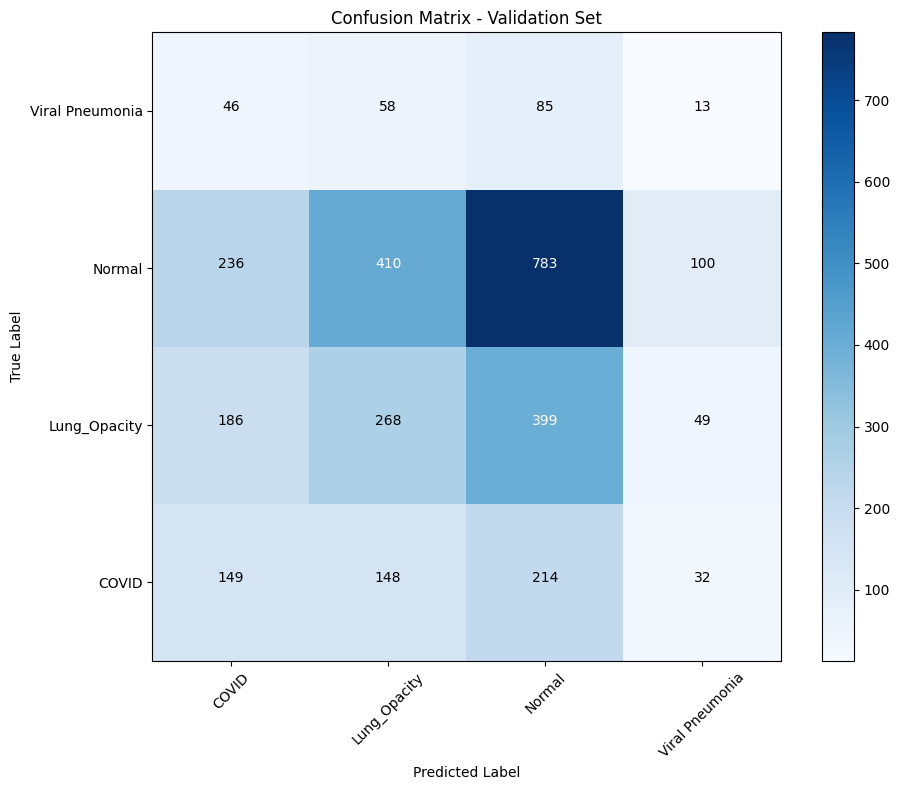


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.28      0.30      0.29       542
   Lung_Opacity       0.34      0.35      0.34       902
         Normal       0.54      0.52      0.53      1529
Viral Pneumonia       0.11      0.11      0.11       202

       accuracy                           0.41      3175
      macro avg       0.32      0.32      0.32      3175
   weighted avg       0.41      0.41      0.41      3175



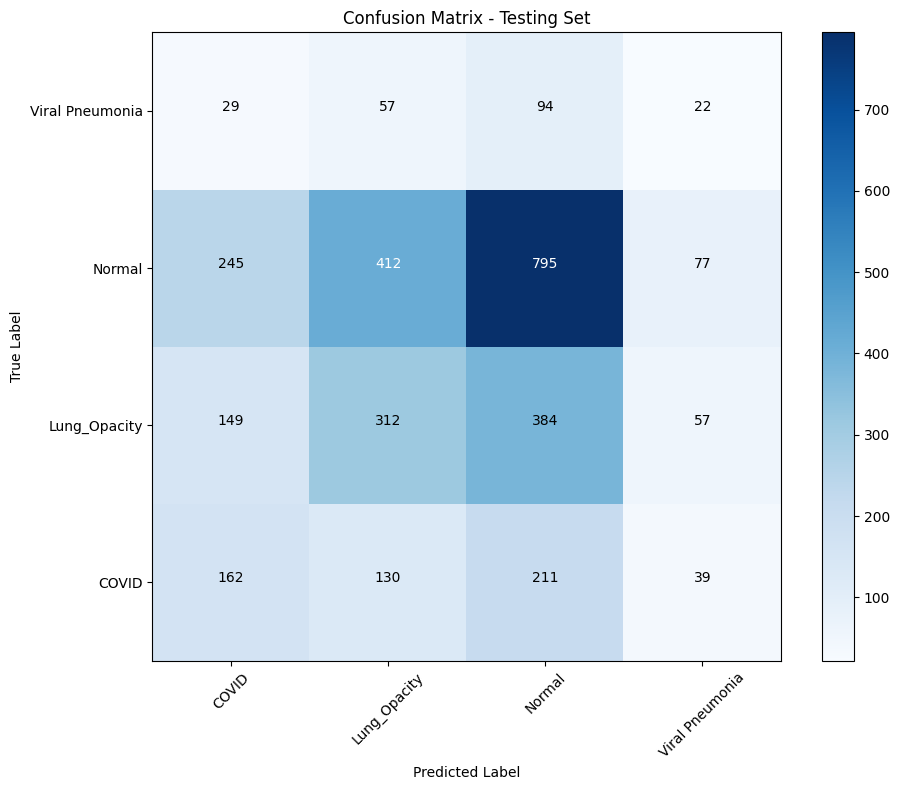

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = decision_tree.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = decision_tree.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```KNN```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.41      0.34       543
   Lung_Opacity       0.35      0.38      0.36       902
         Normal       0.59      0.56      0.57      1529
Viral Pneumonia       0.38      0.04      0.07       202

       accuracy                           0.45      3176
      macro avg       0.41      0.35      0.34      3176
   weighted avg       0.46      0.45      0.44      3176



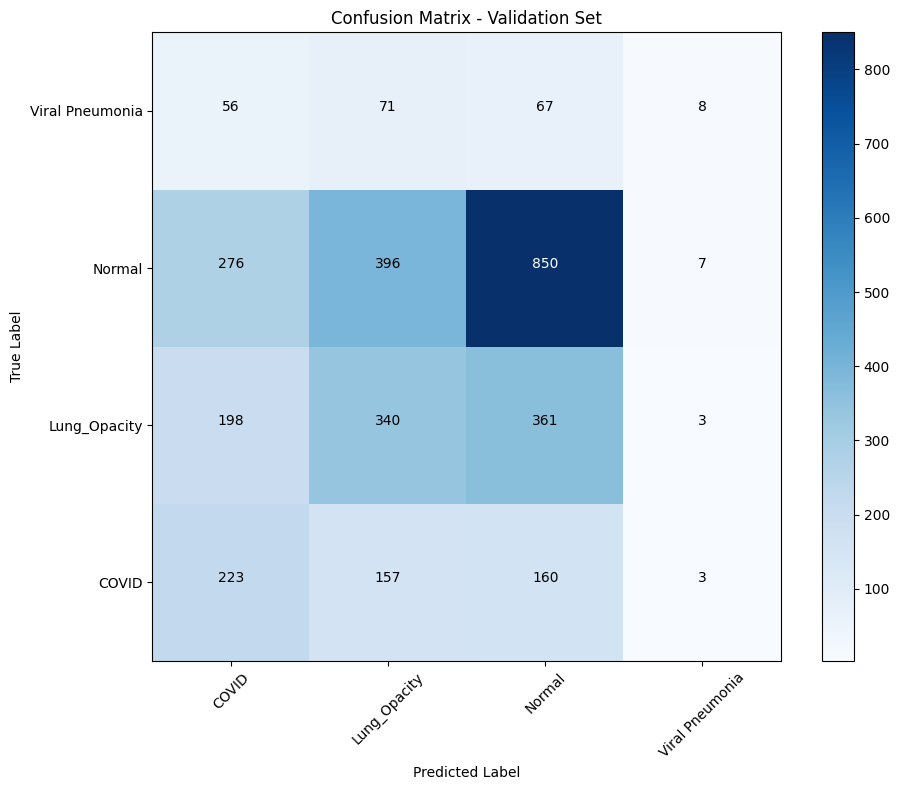


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.34      0.44      0.38       542
   Lung_Opacity       0.35      0.38      0.37       902
         Normal       0.59      0.58      0.58      1529
Viral Pneumonia       0.36      0.05      0.09       202

       accuracy                           0.46      3175
      macro avg       0.41      0.36      0.36      3175
   weighted avg       0.47      0.46      0.46      3175



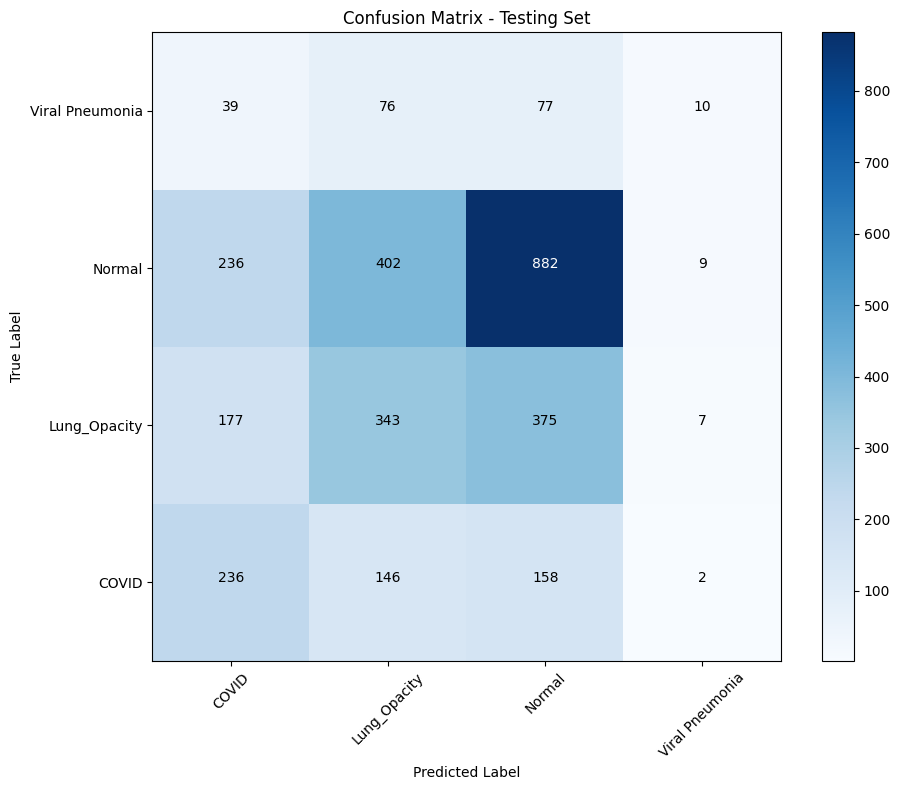

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
Knn_classifier = KNeighborsClassifier()
Knn_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = Knn_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = Knn_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```Naive Bayes```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.30      0.18      0.22       543
   Lung_Opacity       0.45      0.09      0.15       902
         Normal       0.55      0.80      0.65      1529
Viral Pneumonia       0.25      0.52      0.33       202

       accuracy                           0.48      3176
      macro avg       0.39      0.40      0.34      3176
   weighted avg       0.46      0.48      0.42      3176



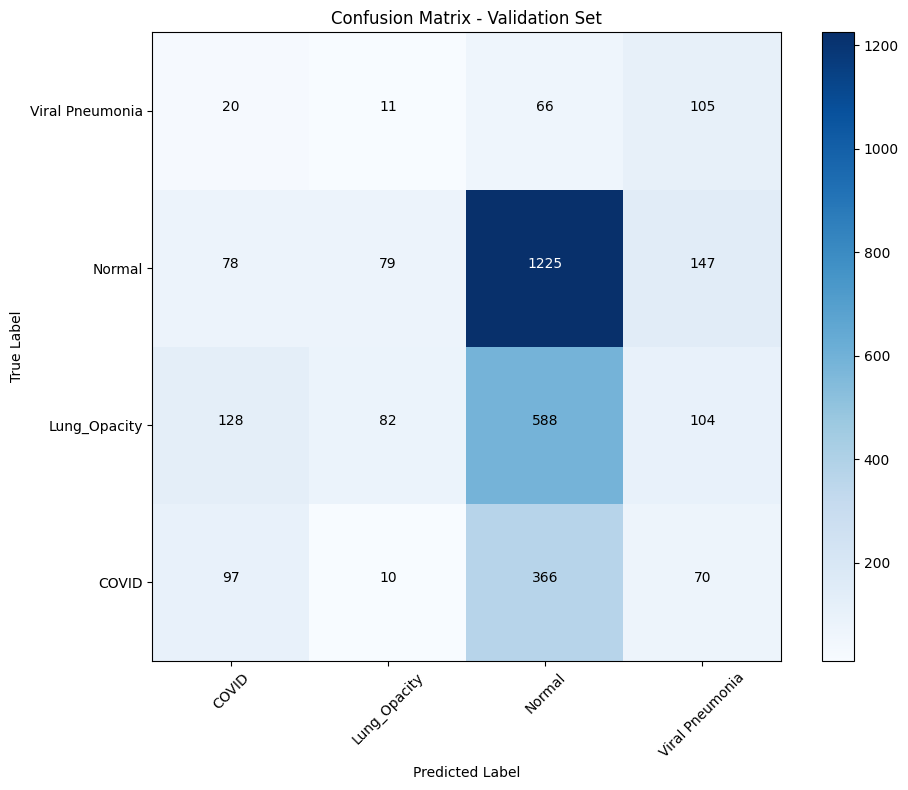


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.33      0.19      0.24       542
   Lung_Opacity       0.45      0.11      0.18       902
         Normal       0.54      0.79      0.64      1529
Viral Pneumonia       0.20      0.41      0.27       202

       accuracy                           0.47      3175
      macro avg       0.38      0.37      0.33      3175
   weighted avg       0.46      0.47      0.42      3175



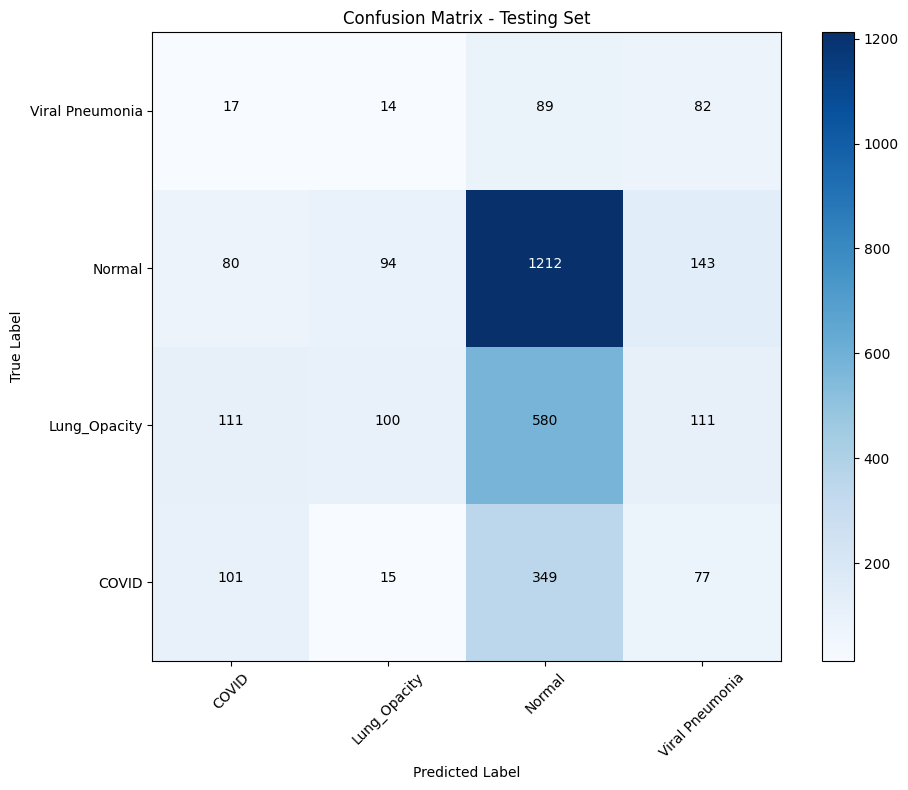

In [ ]:
from sklearn.naive_bayes import GaussianNB

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
NB_classifier = GaussianNB()
NB_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = NB_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = NB_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

##### ```SVM```

Validation Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.40      0.21      0.27       543
   Lung_Opacity       0.47      0.23      0.31       902
         Normal       0.54      0.87      0.66      1529
Viral Pneumonia       1.00      0.01      0.02       202

       accuracy                           0.52      3176
      macro avg       0.60      0.33      0.32      3176
   weighted avg       0.52      0.52      0.46      3176



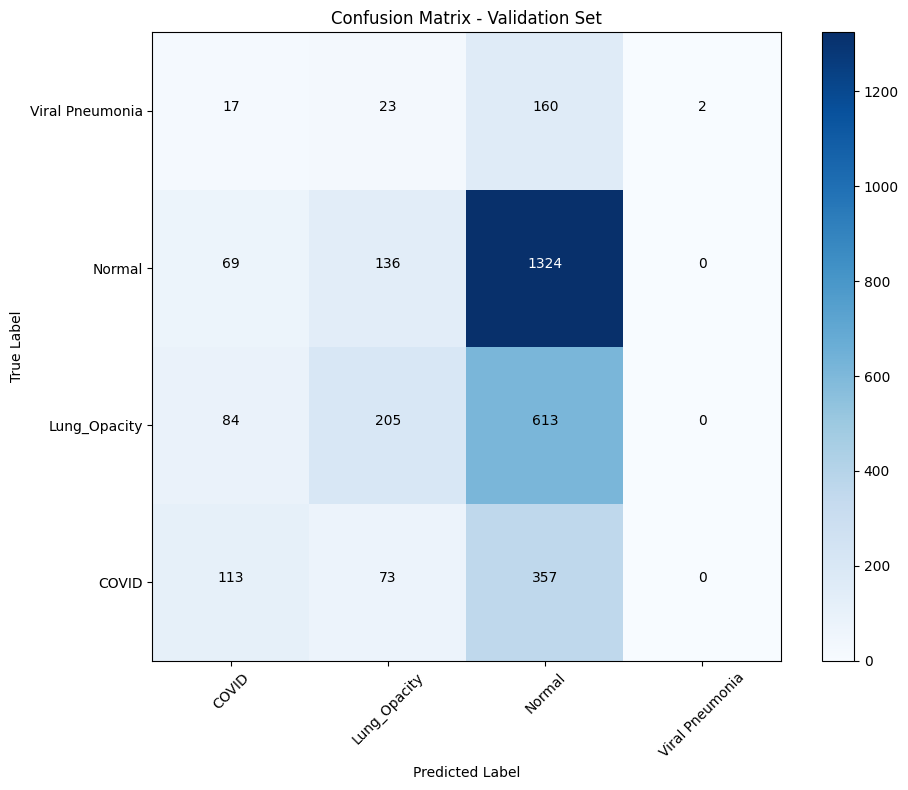


Testing Set Metrics:
                 precision    recall  f1-score   support

          COVID       0.51      0.26      0.34       542
   Lung_Opacity       0.48      0.22      0.30       902
         Normal       0.54      0.88      0.67      1529
Viral Pneumonia       1.00      0.01      0.02       202

       accuracy                           0.53      3175
      macro avg       0.63      0.34      0.33      3175
   weighted avg       0.55      0.53      0.47      3175



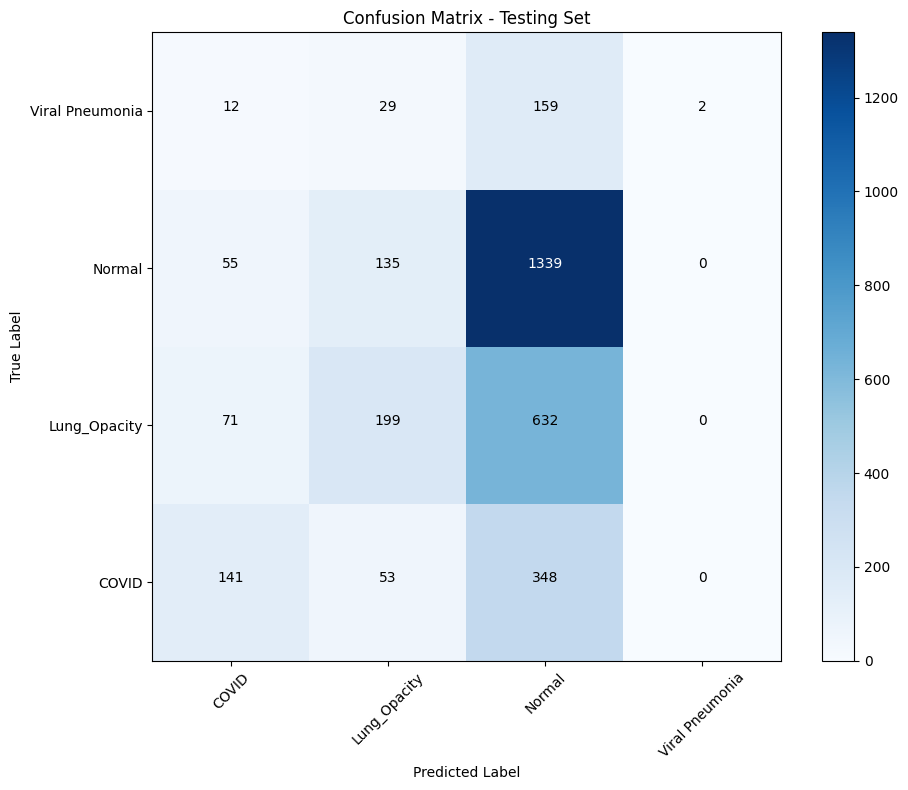

In [ ]:
from sklearn import svm

X_train_orb = approach3_extract_orb_features(X_train,max_val)

# Train a Model
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_orb, y_train)

# Load Validation Data
X_val, y_val = load_images_from_folder(validation_set)

# Extract ORB Features for Validation Data
X_val_orb = approach3_extract_orb_features(X_val,max_val)

# Evaluate Model on Validation Set
val_predictions = svm_classifier.predict(X_val_orb)

# Print classification report for validation set
print("Validation Set Metrics:")
print(classification_report(y_val, val_predictions))

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_val, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Validation Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val), rotation=45)
plt.yticks(tick_marks, np.unique(y_val))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_val)):
    for j in range(len(cm_val[i])):
        plt.text(j, i, format(cm_val[i, j], 'd'), horizontalalignment="center", color="white" if cm_val[i, j] > np.max(cm_val) / 2. else "black")
plt.tight_layout()
plt.show()

# Load Testing Data
X_test, y_test = load_images_from_folder(testing_set)

# Extract ORB Features for Testing Data
X_test_orb = approach3_extract_orb_features(X_test,max_val)

# Evaluate Model on Testing Set
test_predictions = svm_classifier.predict(X_test_orb)

# Print classification report for testing set
print("\nTesting Set Metrics:")
print(classification_report(y_test, test_predictions))

# Plot confusion matrix for testing set
cm_test = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
plt.imshow(cm_test, interpolation='nearest', cmap='Blues', origin='lower')
plt.title('Confusion Matrix - Testing Set')
plt.gca().set_facecolor('black')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
for i in range(len(cm_test)):
    for j in range(len(cm_test[i])):
        plt.text(j, i, format(cm_test[i, j], 'd'), horizontalalignment="center", color="white" if cm_test[i, j] > np.max(cm_test) / 2. else "black")
plt.tight_layout()
plt.show()

### **SIFT**